# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib, seaborn as sns, astropy.units as u

from astropy.io import votable, ascii
from astropy.coordinates import SkyCoord
from gdpyc.core import GasMap, DustMap
from scipy import interpolate, stats, optimize

from code.utilities import custom_iter, split_filters, new_since_Fong, literature_references, addYear
from code.xrt import XRT_lightcurve, get_photonIndex, get_temporalIndex, get_columnDensity
from code.uncertainty import AsymmetricUncertainty, UncertaintyArray
from code.fluxtools import effective_wavelength, lightcurve, simulate_spectrum

#calc_code = importlib.import_module("legacy.Calculation Code.calc_beta_ox")
#graph_code = importlib.import_module("legacy.Graphing Code.Graphing_Beta_OX")

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"
UVOT_conversions = {'V': -0.01, 'B': -0.13, 'U': 1.02, 'UVW1': 1.51, 'UVM2': 1.69, 'UVW2': 1.73, 'White': 0.8}

In [ ]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
for grb in swift[swift["TriggerNumber"].apply(pd.to_numeric,errors="coerce").isna()]["GRB"]: # non-Swift bursts
    bat_data = pd.read_html(f"https://swift.gsfc.nasa.gov/archive/grb_table/fullview/{grb}/")[0]
    T90 = bat_data.loc[bat_data[0]=="T90: c",1].values # get the T90 anyway, if it exists
    swift.loc[swift["GRB"]==grb,"BAT T90[sec]"] = pd.to_numeric(T90, errors="coerce")

In [ ]:
valid = ['050509B', '050724', '051103', '051105', '051114', '051211A', '051221', '060427B',
         '060429', '060502B', '070124', '070201', '070429B', '070714B', '070810B', '071112B',
         '080905', '080913', '081211B', '081216', '081223', '090531B', '090715A', '090916A',
         '090927A', '091117A', '091126B', '100213A', '100216A', '100816A', '110402A', '110802A',
         '120811B', '120830A', '140428B', '140604A', '150118C', '150424A', '150906B', '150922A',
         '151221A', '160111A', '160219A', '160406A', '160620A', '160709A', '160820A', '160822A',
         '160825A', '160829A', '161004A', '170127C', '170206A', '170219A', '170220A', '170222A',
         '170403A', '170616A', '170708A', '170728B', '170805A', '170805B', '170816A', '170817A',
         '170822A', '170825A', '170826A', '170827A', '170827B', '170921B', '171030A', '171103A',
         '171106A', '171223A', '180317A', '180418A', '180529A', '180618A', '180626C', '180715B',
         '180716A', '180728B', '180824A', '181121A', '181126B', '181222B', '181225A', '190121A',
         '190206A', '190331C', '190606A', '190626B', '190630A', '190719C', '190724A', '190810A',
         '190813A', '190830B', '190831B', '190903A', '190913A', '191017C', '191101B', '191116A',
         '191203A', '191221A', '200103A', '200128A', '200128B', '200129A', '200212A', '200219A',
         '200221A', '200224C', '200306B', '200307A', '200308A', '200313B', '200325A', '200327A',
         '200401A', '200405B', '200420A', '200423A', '200501A', '200506B', '200509B', '200514B',
         '200521A', '200605A', '200623B', '200626A', '200703A', '200706A', '200710A', '200714B',
         '200716C', '200718A', '200805A', '200815A', '200817A', '200824A', '200826A', '200903C',
         '200907A', '200908A', '200916B', '200920A', '200920B', '200923A', '200928A', '201103A',
         '201108A', '201109A', '201111A', '201130A', '201214B', '201221B', '201222A', '201227A',
         '210124B', '210205B', '210307B', '210326A', '210410A', '210421C', '210424B', '210425A',
         '210506A', '210510A', '210529A', '210529B', '210601A', '210605A'] # flagged from GCN Circulars

valid += ['050202', '050509B', '050709', '050724A', '050813', '050906', '050925',
          '051210', '051221A', '060121', '060313', '060502B', '060801', '061006',
          '061201', '061210', '061217', '070209', '070406', '070429B', '070707',
          '070714B', '070724A', '070729', '070809', '070810B', '071017', '071112B',
          '071227', '080121', '080123', '080426', '080503', '080702A', '080905A',
          '080919', '081024A', '081024B', '081226A', '081226B', '090305', '090305A',
          '090426', '090426A', '090510', '090515', '090607', '090621B', '090916',
          '091109B', '091117', '100117A', '100206A', '100213', '100625A', '100628A',
          '100702A', '101219A', '101224A', '110112A', '110112B', '110420B', '111020A',
          '111117A', '111121A', '111222A', '120229A', '120305A', '120521A', '120630A',
          '120804A', '120817B', '121226A', '130313A', '130515A', '130603B', '130626A',
          '130716A', '130822A', '130912A', '131004A', '131125A', '131126A', '131224A',
          '140129B', '140320A', '140402A', '140414A', '140516A', '140606A', '140619B',
          '140622A', '140903A', '140930B', '141202A', '141205A', '141212A', '150101A',
          '150101B', '150120A', '150301A'] # Fong, et al.

valid += ['130313A', '130822A', '130912A', '140903A', '141212A', '150120A', '150423A',
          '150831A', '160303A', '160408A', '160410A', '160411A', '160601A', '160612A',
          '160624A', '161001A', '170112A', '170127B', '170428A', '170524A', '180715A',
          '180718A', '180727A', '180805B', '181126A', '190427A', '191031D', '200623A',
          '201221D'] # Rastinejad, et al.

In [ ]:
sGRBs = swift[(swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2) | swift["GRB"].isin(valid)].copy() # filter catalog for GRBs with a valid T90 that is <2s

### Data parsing and cleanup

In [ ]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)',
            'BAT Photon Index90% Error(15-150 keV)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]','XRT InitialTemporalIndex':"α",
                      'XRTSpectral Index(Gamma)':'Γ','UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters',"XRT RA(J2000)":"RA","XRT Dec(J2000)":"Dec"},inplace=True)

In [ ]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs.loc[obs["idx"], "Other UVOT Filters"] = obs.copy()

In [ ]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [3]:
sGRBs = pd.read_csv("./products/Swift_sGRB_catalog.csv")
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],α,Γ,UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,Beta_X,Beta_X_neg,Beta_X_pos,UVOT Vmag,UVOT Vmag lim,N_H (intrinsic)
0,210413B,1043009,1.088,NaN,NaN,NaN,185000.0,NaN,{'idx': 19},NaN,NaN,NaN,NaN,NaN,NaN,equal,NaN
1,210410A,1042113,52.88,61.00,-3.372,1.43013,1113.0,V>17.0,"{'B': '19.7', 'U': '19.9', 'UVM2': '19.4', 'UV...","Fermi (GBM & LAT), Ondrejov D50, AGILE, HJT (1...",NaN,0.45,0.17,0.18,17.0,brightest,"4e+20 (+6e+20, -4e+20)"
2,210323A,1038247,1.12,85.20,-1.687,1.72358,89.0,V>17.7,"{'B': '19.3', 'U': '19.3', 'UVM2': '18.8', 'UV...","NOT, AZT-33IK (Mondy), Fermi (GBM), Konus-Wind...",NaN,0.70,0.20,0.20,17.7,brightest,"1.76e+21 (+1.0200000000000001e+21, -8.90000000..."
3,210119A,1017711,0.06,NaN,NaN,NaN,NaN,NaN,{'idx': 45},"Fermi (GBM), MASTER-OAFA, Insight-HXMT/HE, GEC...",NaN,NaN,NaN,NaN,NaN,equal,NaN
4,201221D,1014037,0.16,87.42,NaN,1.28331,92.0,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,0.10,0.47,1.05,19.2,brightest,"0.0 (+2.68e+22, -0.0)"


### Legacy and new data imports

In [4]:
BetaXData = pd.read_csv("./data/BetaXData.csv", header=None, names=["GRB","Beta_X","Beta_X_pos","Beta_X_neg"])
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]
BetaXData["Beta_X"] *= -1

OpticalData = pd.read_csv("./data/OpticalData.csv", header=None, names=["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"])
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
OpticalData["Time"] *= 60*60

filters = pd.read_csv("./data/FilterInfo.csv", header=None, names=["Observatory","Instrument","Filter","Wavelength","Frequency"])
OpticalData = OpticalData.merge(filters,how="left",on=["Observatory","Instrument","Filter"])

XRayData = pd.read_csv("./data/XRayData.csv", header=None, names=["GRB","Time","Exposure","F_x","e_F_x"])

In [5]:
new_sGRBs = new_since_Fong(sGRBs) # Fong et al. (2015) has data up to March 2015, i.e. GRB 150301A

## X-ray

### Swift XRT light curves and spectra

In [ ]:
burst = "051221A"
fluxdata = XRT_lightcurve(burst,sGRBs)
Gamma,mode = get_photonIndex(burst,sGRBs)
NH,mode = get_columnDensity(burst,sGRBs)

In [ ]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma.value-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma.maximum-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma.minimum-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
#plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density (log scale)")
plt.show()

In [ ]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gamma.minus,Gamma.plus))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")

plt.show()

In [6]:
xrt_data = pd.read_csv("./products/Swift_XRT_lightcurves.csv")
# xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
# for i in sGRBs.index:
#     GRB_ID = sGRBs.loc[i,"GRB"]
#     print(GRB_ID+" "*(7-len(GRB_ID)),end=": ")
#     mode = None
#     try:
#         Gamma,mode = get_photonIndex(GRB_ID,sGRBs)
#         sGRBs.loc[i,"Beta_X"] = Gamma.value - 1
#         sGRBs.loc[i,"Beta_X_neg"] = Gamma.minus
#         sGRBs.loc[i,"Beta_X_pos"] = Gamma.plus
#         print("index ✓",end=", ")
#     except:
#         print("index ✗",end=", ")
#     try:
#         fluxdata = XRT_lightcurve(GRB_ID,sGRBs)
#         xrt_data = xrt_data.append(fluxdata,ignore_index=True)
#         print("lightcurve ✓",end=" ")
#     except:
#         print("lightcurve ✗",end=" ")
#     if mode=="WT":
#         print("(used WT spectrum)")
#     else:
#         print()
        
# # account for upper limits
# xrt_data.loc[xrt_data["Fluxneg"]==0, "Fluxneg"] = [np.inf]*len(xrt_data[xrt_data["Fluxneg"]==0])

### X-ray flux values to spectral flux density conversions

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [7]:
for i,row in xrt_data.iterrows():
    grb_id = row["GRB"]
    if grb_id not in sGRBs["GRB"].values:
        continue
    beta = AsymmetricUncertainty(float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # 90% conf to 1-sigma
                                 float(sGRBs.loc[sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(row["Flux"], row["Fluxpos"], np.abs(row["Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10))) # halfway between the endpoints in log space

    dfdF = (log_mean_energy**(-B))/integral
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*Fx.value/integral #- log_mean_energy**(-B)*(1-B)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-B)-0.3**(1-B))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-B)-0.3**(1-B))
    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

### Fong, et al. (2015)'s X-ray data

In [8]:
for grb_id in XRayData["GRB"].unique(): # add David's old data in the same format
    GRB = grb_id[3:]
    lightcurve = XRayData.loc[XRayData["GRB"]==grb_id,:]
    if GRB not in xrt_data["GRB"].values:
        print(GRB,end=", ")
        for i in lightcurve.index:
            t = lightcurve.loc[i,"Time"]
            tpos = tneg = lightcurve.loc[i,"Exposure"]/2
            flux = lightcurve.loc[i,"F_x"]/1e6 # uJy to Jy
            if lightcurve.loc[i,"e_F_x"] != 0:
                fluxpos = fluxneg = lightcurve.loc[i,"e_F_x"]/1000000
            else:
                fluxpos = 0
                fluxneg = np.inf
            newrow = dict(zip(xrt_data.columns,
                              [GRB,t,tpos,tneg,np.nan,np.nan,np.nan,AsymmetricUncertainty(flux,fluxpos,fluxneg)]))
            xrt_data = xrt_data.append(newrow, ignore_index=True)
            
xrt_data.sort_values(by=["GRB","Time"], ascending=[False,True], inplace=True)

050709, 050724A, 050813, 050906, 050925, 060502B, 070209, 070406, 070707, 070810B, 071017, 071112B, 080121, 081226B, 090305A, 090426A, 090916, 100213, 100628A, 101224A, 110112B, 111222A, 120817B, 130313A, 130626A, 131224A, 140402A, 140414A, 140606A, 140619B, 141202A, 141205A, 150101B, 

## Optical

### Load new optical data

In [22]:
new_optical = pd.read_excel("./data/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical["Magnitude"] = pd.to_numeric(new_optical["Magnitude"],errors="coerce")
new_optical.dropna(subset=["Magnitude"],inplace=True)

rastinejad = pd.read_csv("./data/Rastinejad_Table1.csv")
for i in rastinejad.index:
    info = {}
    info["GRB"] = rastinejad.loc[i,"GRB"]
    if "/" in rastinejad.loc[i,"Telescope/Instrument"]:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[0]
        info["Instrument"] = rastinejad.loc[i,"Telescope/Instrument"].split("/")[1]
    else:
        info["Observatory"] = rastinejad.loc[i,"Telescope/Instrument"]
    info["Filter"] = rastinejad.loc[i,"Filter"]
    info["Time (s)"] = float(rastinejad.loc[i,"dt [sec]"])
    if ">" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].replace(">",""))
        info["Mag error"] = "3-sigma"
    elif "+/-" in rastinejad.loc[i,"Magnitude"]:
        info["Magnitude"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[0])
        info["Mag error"] = float(rastinejad.loc[i,"Magnitude"].split(" +/- ")[1])
    info["λ_eff"] = float(rastinejad.loc[i,"Wavelength"])
    info["Source"] = "Rastinejad"
    info["E(B-V)"] = float(rastinejad.loc[i,"E(B-V)"])
    new_optical = new_optical.append(info,ignore_index=True)

*Swift*-UVOT magnitudes are natively in the Vega system. Here I standardize the filter names and apply the appropriate conversions to put them in AB.

In [23]:
for i in new_optical.loc[new_optical["Observatory"]=="Swift"].index:
    filt = new_optical.loc[i,"Filter"]
    if filt in UVOT_conversions.keys() or pd.isna(filt):
        pass
    elif filt.upper() in UVOT_conversions.keys():
        new_optical.loc[i,"Filter"] = filt.upper()
    elif filt.title() in UVOT_conversions.keys():
        new_optical.loc[i,"Filter"] = filt.title()
    elif filt[-3:] == "_FC":
        new_optical.loc[i,"Filter"] = filt[:-3].title()
    elif str("UV"+filt).upper() in UVOT_conversions.keys():
        new_optical.loc[i,"Filter"] = str("UV"+filt).upper()
    elif filt == 'um2':
        new_optical.loc[i,"Filter"] = "UVM2"
    elif filt == 'uw1':
        new_optical.loc[i,"Filter"] = "UVW1"
    elif filt == 'uw2':
        new_optical.loc[i,"Filter"] = "UVW2"
        
    new_optical.loc[i,"Magnitude"] += UVOT_conversions[new_optical.loc[i,"Filter"]]

In [24]:
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

### Filter transmission calculations

In [ ]:
# I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
# rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
# rprime_filter.columns = ["Wavelength","Transmission"]
# rprime_filter["Wavelength"] *= 10
# MOSFIRE_J = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_J.txt",delimiter="   ").iloc[:,:2]
# MOSFIRE_J = MOSFIRE_J.rename(columns=dict(zip(MOSFIRE_J.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
# MOSFIRE_J["Wavelength"] *= 10000
# MOSFIRE_J["Transmission"] *= 100

# MOSFIRE_K = pd.read_table("https://www2.keck.hawaii.edu/inst/mosfire/data/filter/mosfire_K.txt",delimiter="   ",engine='python').iloc[:,:2]
# MOSFIRE_K = MOSFIRE_K.rename(columns=dict(zip(MOSFIRE_K.columns,["Wavelength","Transmission"]))).apply(pd.to_numeric,errors="coerce").dropna()
# MOSFIRE_K["Wavelength"] *= 10000
# MOSFIRE_K["Transmission"] *= 100

# REMIR_H = pd.read_csv("./data/REM/H.csv",header=None,names=["Wavelength","Transmission"])
# REMIR_H["Wavelength"] *= 10

LDSS3_i = pd.read_table("http://www.lco.cl/wp-content/uploads/telescopes/magellan/instruments/ldss3/filters-data/i01.txt",
                        header=None,names=["Wavelength","Transmission"])
LDSS3_i["Wavelength"] *= 10
effective_wavelength(LDSS3_i,dl=1,show_plot=True)

### Extinction correction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

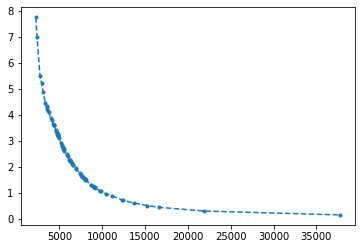

In [25]:
RbTable = pd.read_csv("./data/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"],fill_value="extrapolate") # function that takes a wavelength [Ang] and returns the corresponding R_b value

RbTable.drop([37,55,61,73],axis=0,inplace=True) # smoothing
RbTable.sort_values(by="lambda_eff",inplace=True)
plt.plot(RbTable.lambda_eff, RbTable.R_b, ".--")

### Optical magnitude to spectral flux density conversions

In [26]:
new_optical["Extinction"] = Rb(new_optical["λ_eff"])*new_optical["E(B-V)"]

In [27]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at f_nu = 3631 Jy

### Fong, et al. (2015)'s optical data

In [30]:
all_optical = new_optical.copy()

for i in OpticalData.index:
    GRB = OpticalData.loc[i,"GRB"]
    obs = OpticalData.loc[i,"Observatory"]
    inst = OpticalData.loc[i,"Instrument"]
    filt = OpticalData.loc[i,"Filter"]
    time = OpticalData.loc[i,"Time"]
    lambda_eff = OpticalData.loc[i,"Wavelength"]*10
    flux = OpticalData.loc[i,"F_o"]/1e6
    fluxpos = fluxneg = OpticalData.loc[i,"e_F_o"]/1e6
    if fluxneg == 0:
        fluxneg = np.inf
    newrow = {'GRB':GRB, 'Observatory':obs, 'Instrument':inst,'Filter':filt, 'λ_eff':lambda_eff,
              'Time (s)':time, 'Source':'Fong', 'Flux (Jy)':AsymmetricUncertainty(flux,fluxpos,fluxneg)}
    all_optical = all_optical.append(newrow, ignore_index=True)
    
all_optical.sort_values(by=["GRB","Time (s)"],ascending=[False,True],inplace=True)

## Information compilation

### Match data points in time

In [43]:
max_dt = 0.15 # allowable % time difference
log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))
nu_x = AsymmetricUncertainty(log_mean_energy,10-log_mean_energy,log_mean_energy-0.3) * 241797944177033445 # xray frequency [Hz]
results = pd.DataFrame(columns=["GRB","t_o","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in all_optical.index: # for each optical data point
    t_o = all_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = all_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(all_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [Hz]
    for i_x in xrt_data[xrt_data["GRB"]==all_optical.loc[i_o,"GRB"]].index: # for each x-ray data point on this GRB
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_x # time difference
        if dt <= max_dt: # if time separation is allowable
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox.value):
                results = results.append({"GRB":all_optical.loc[i_o,"GRB"], "t_o":t_o, "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # if data points don't match
            pass

### Incorporate error in $\beta_\text{ox}$ due to temoral separation ($\Delta\beta_\text{ox}$)

In [ ]:
for (grb,t_o),matches in results.groupby(["GRB","t_o"]):
    except:
        a = get_temporalIndex(grb,t_o,sGRBs)
        results.loc[matches.index,"α"] = [a.value]*len(matches.index)
    finally:
        a = 1
        results.loc[matches.index,"α"] = [a]*len(matches.index)
    print(grb,t_o,a)

In [ ]:
delta_B_ox = lambda dt, alpha=1 : np.abs(alpha*np.log10(1+dt)) # Fitzpatrick Eq. 41

results["B_ox_w_err"] = [match["B_ox"].add_error(delta_B_ox(match["dt%"],match["α"])) for _,match in results.iterrows()]

### Previously retreived x-ray spectral indices for comparison

In [45]:
all_beta_x = sGRBs[["GRB","Beta_X","Beta_X_pos","Beta_X_neg"]].copy() # table of all xray spectral indices
results = results.merge(all_beta_x,on="GRB",how="left") # match by GRB ID
results["B_x"] = [AsymmetricUncertainty(*results.loc[i,["Beta_X","Beta_X_pos","Beta_X_neg"]]) for i in results.index] # construct objects
results.drop(['Beta_X', 'Beta_X_pos', 'Beta_X_neg'],axis=1,inplace=True) # discard superfluous columns

# add flag columns for darkness by both methods
for i in results.index: # '<<' operator is overloaded for use with AsymmetricUncertainty class
    results.loc[i,"Jak_dark"] = (results.loc[i,"B_ox"] < 0.5)
    results.loc[i,"vdH_dark"] = (results.loc[i,"B_ox"] < results.loc[i,"B_x"]-0.5)

results.sort_values(by=["GRB","t_o"],ascending=[False,True]).sample(5)

,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
1857,060313,4680.00,0.092052,6.828985e+14,1.87e-05 ± 5.3e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,4.556135284151477e-07 ± 1.0397185459842359e-07,"0.578709994571451 (+0.0824744640182345, -0.431...","0.8460000000000001 (+0.12, -0.087)",False,False
1686,130603B,21960.00,0.000325,3.059107e+14,2.5399999999999997e-05 ± 1.4e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,1.2702892756693632e-07 ± 2.8705854339703575e-08,"0.733617343661548 (+0.08959546164021129, -0.48...","0.97 (+0.14, -0.13)",False,False
540,180418A,10710.65,0.082561,3.980626e+14,1.5468653897952988e-05 ± 1.4247156749644317e-06,4.1880632448032506e+17 (+1.9991731172900093e+1...,8.437898720576166e-08 ± 2.2309430406921384e-08,"0.7488986955152089 (+0.09753309289754414, -0.5...","0.94 (+0.27, -0.25)",False,False
558,180402A,265.00,0.011054,8.514533e+14,"0.00039361162890082295 (+0.0, -inf)",4.1880632448032506e+17 (+1.9991731172900093e+1...,3.8020479325133502e-06 (+9.316574040565916e-07...,"0.7485738606255232 (+0.10710310691937444, -inf)","0.29 (+0.29, -0.25)",False,False
763,170728B,517.00,0.108067,4.715230e+14,0.00011362887667219093 ± 1.1512166932598012e-05,4.1880632448032506e+17 (+1.9991731172900093e+1...,2.1877825205623998e-05 ± 4.162229560880812e-06,"0.24265967811010392 (+0.04333117435278721, -0....","0.79 (+0.08, -0.07)",True,True


### Determine darkness

In [46]:
dark = results.loc[results["Jak_dark"] | results["vdH_dark"],:].sort_values(by=["GRB","dt%"],ascending=[False,True])

# only accept the closest temporal match for each optical data point
close_times = dark.copy()
for grb_id in close_times["GRB"].unique():
    working = close_times[close_times["GRB"]==grb_id]
    for optical_point in working["F_o"]:
        subworking = close_times[close_times["F_o"]==optical_point]
        closest = subworking["dt%"].min()
        close_times.drop(subworking[subworking["dt%"] != closest].index, axis=0, inplace=True)

# darkest matched pair for each GRB
darkest_times = results.copy()
for grb_id,working in darkest_times.groupby("GRB"):
    darkest_beta = working["B_ox"].min()
    darkest_times.drop(working[working["B_ox"] != darkest_beta].index, axis=0, inplace=True)
    
for GRB in close_times["GRB"].unique():
    print(GRB+"\t",close_times["GRB"].tolist().count(GRB))

210323A	 4
200411A	 3
200219A	 2
191031D	 1
190719C	 6
181123B	 2
180727A	 1
180618A	 8
180418A	 3
180204A	 2
170827A	 2
170822A	 7
170728B	 29
170728A	 1
170127B	 1
161004A	 2
161001A	 1
160821B	 3
160624A	 2
160525B	 1
160408A	 3
151229A	 5
151127A	 1
150831A	 1
150424A	 15
150120A	 1
130912A	 2
120804A	 1
090515	 1
080503	 1
080123	 1
070714B	 4
070707	 2
060313	 5
060121	 8


3 0 1


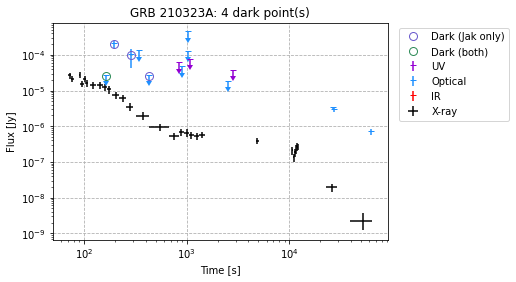

2 0 1


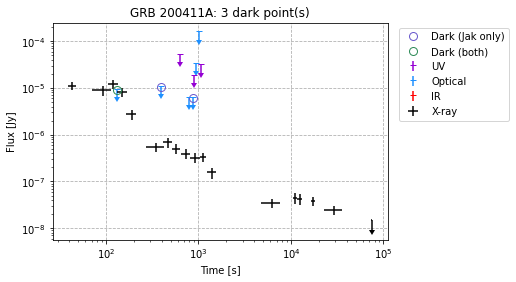

1 0 1


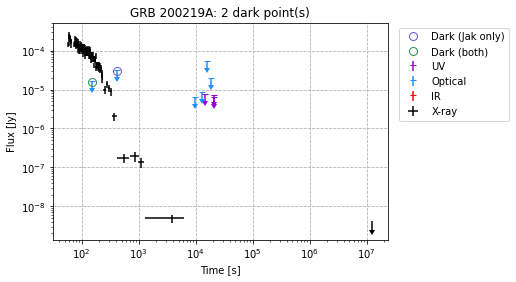

0 0 1


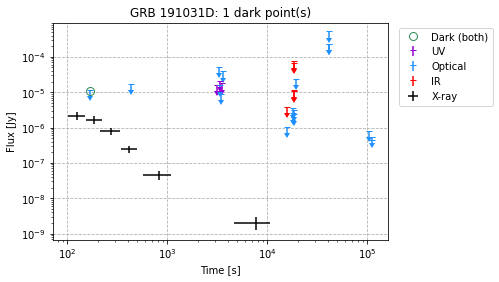

4 0 2


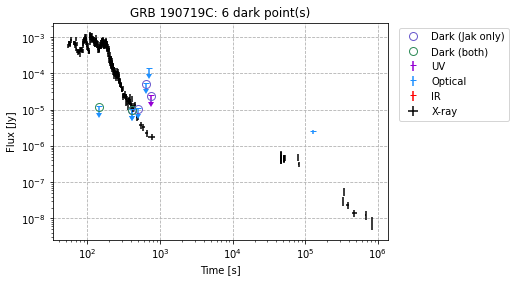

0 1 1


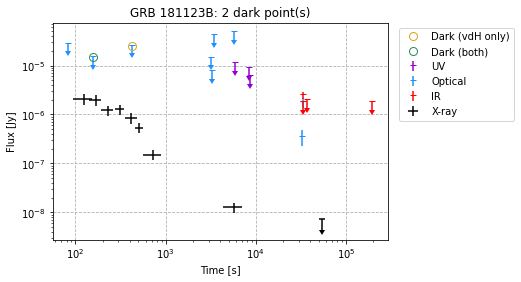

0 0 1


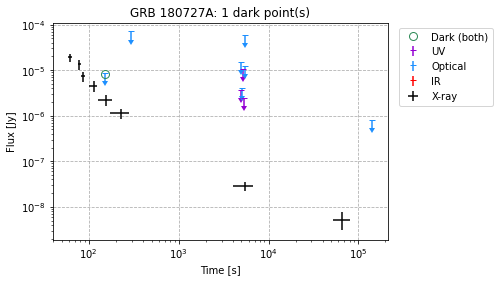

0 7 1


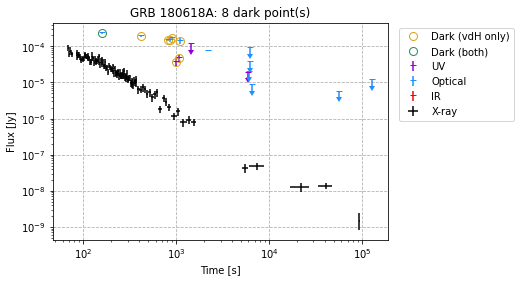

2 0 1


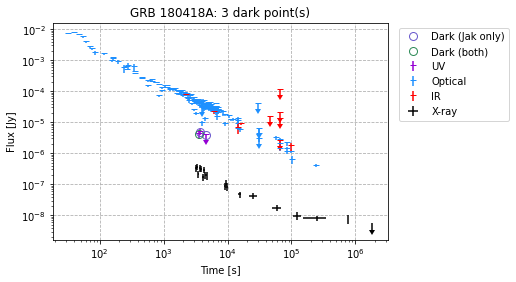

0 0 2


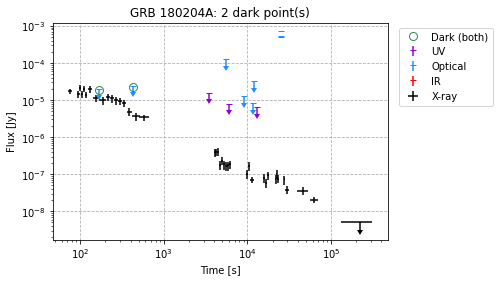

0 0 2


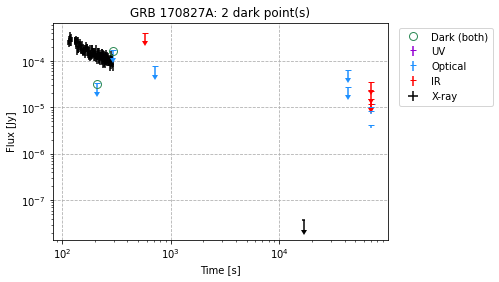

2 0 5


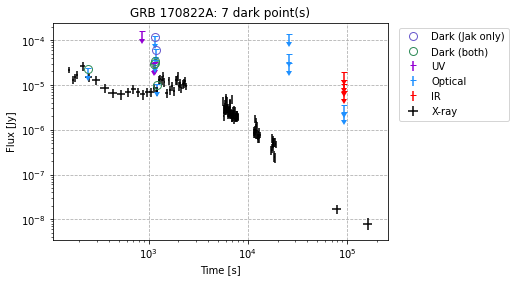

0 0 29


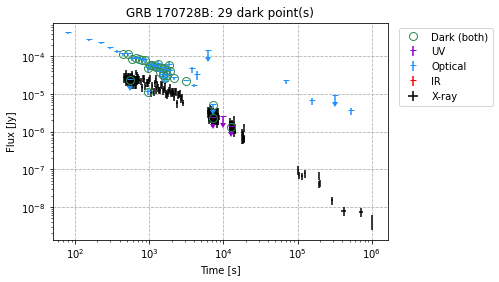

0 1 0


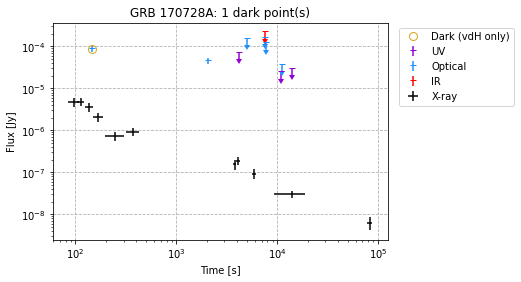

1 0 0


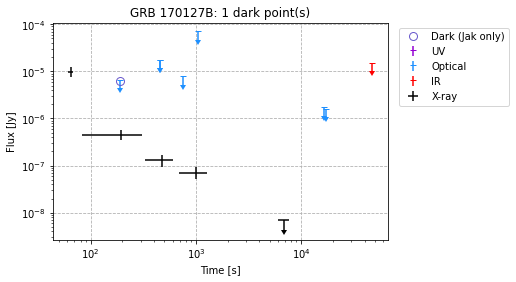

2 0 0


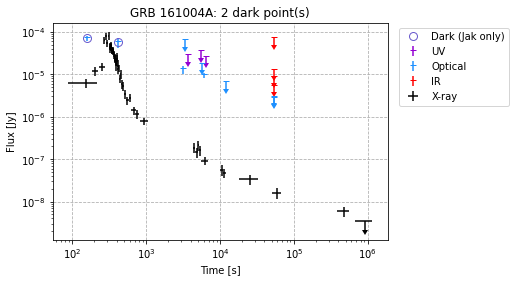

0 0 1


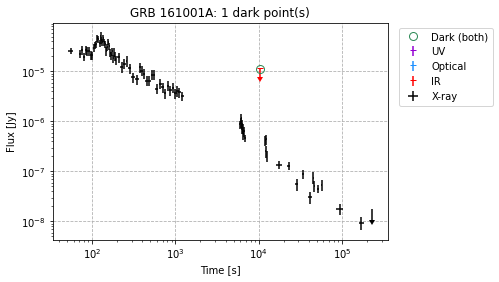

0 0 3


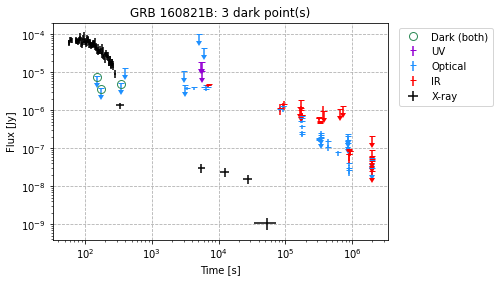

0 0 2


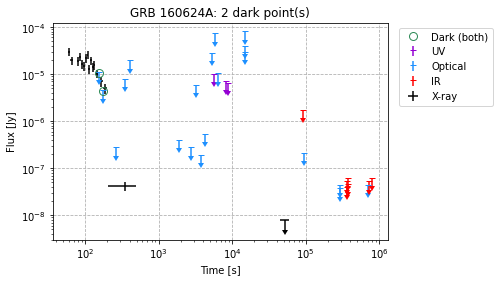

0 0 1


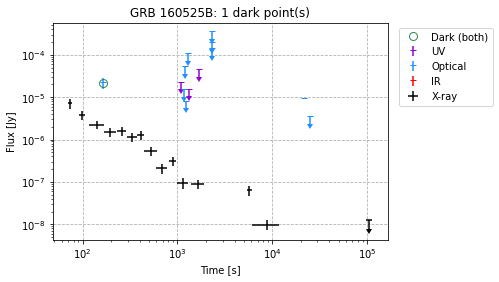

0 1 2


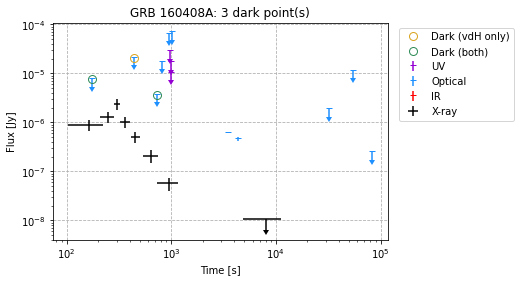

0 0 5


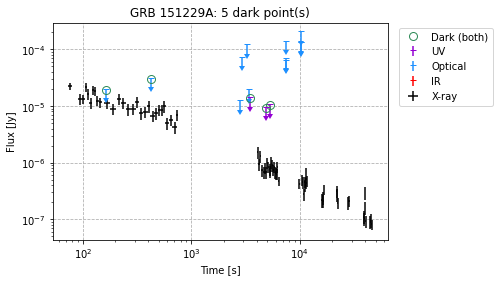

0 1 0


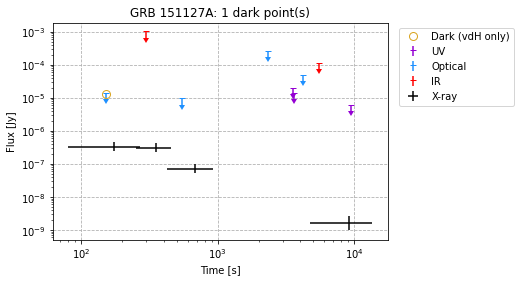

0 0 1


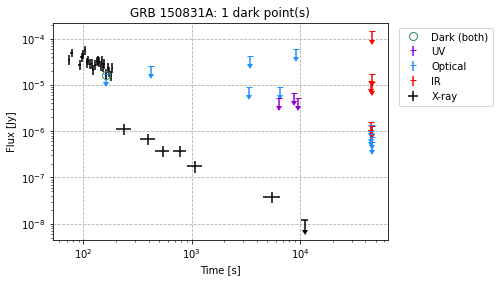

0 5 10


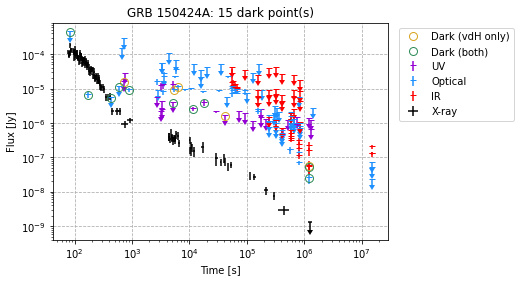

0 0 1


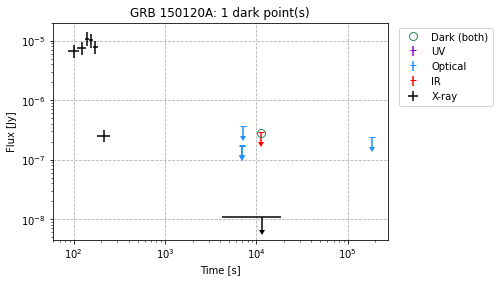

2 0 0


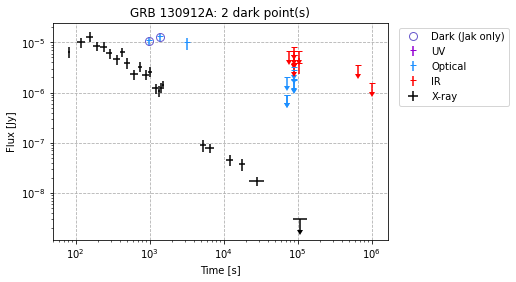

0 0 1


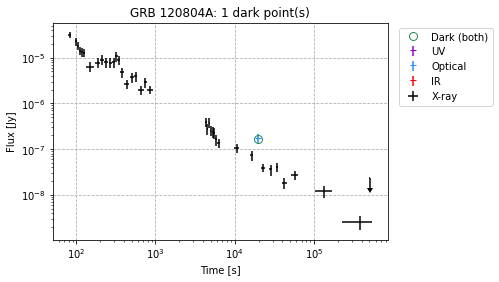

1 0 0


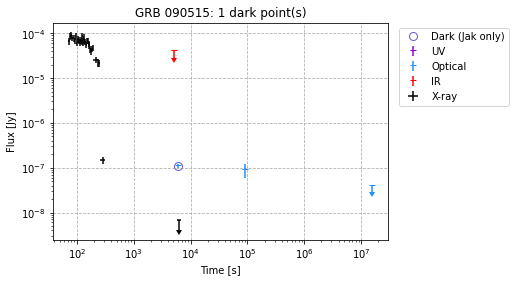

0 0 1


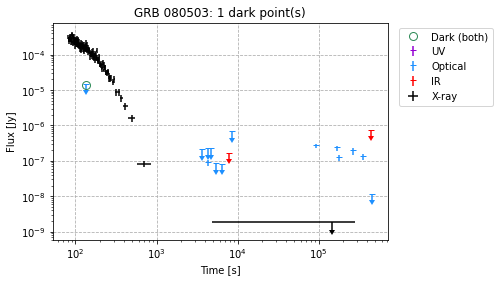

0 0 1


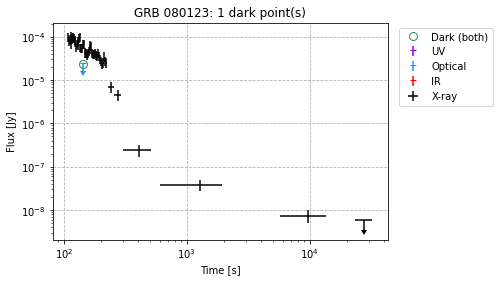

3 0 1


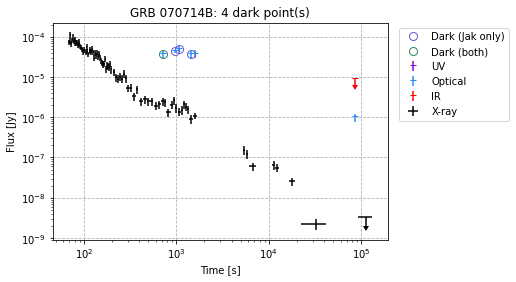

0 0 2


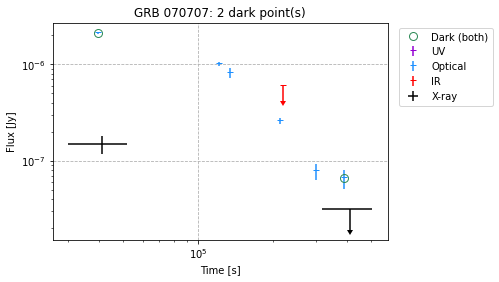

4 0 1


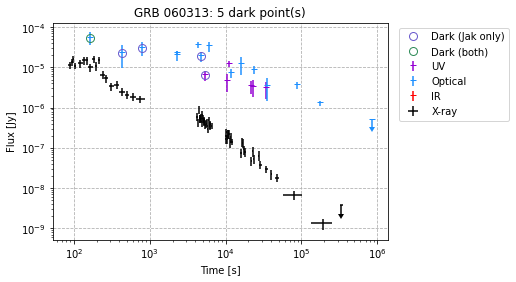

0 2 6


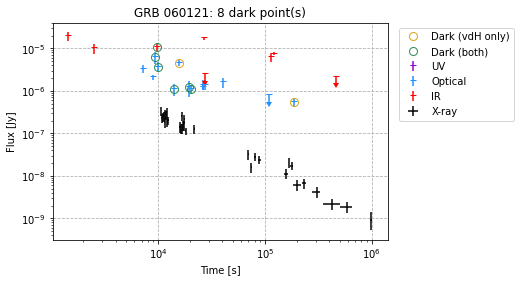

In [47]:
for grb in close_times["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")

    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    print(len(jak),len(vdh),len(both))
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
            marker="o",markersize=8,mfc="none",mec="slateblue",
            linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
            marker="o",markersize=8,mfc="none",mec="goldenrod",
            linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
            marker="o",markersize=8,mfc="none",mec="seagreen",
            linestyle="",label="Dark (both)")
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    fig.savefig(f"./products/dark lightcurves/{grb}.png",dpi=300,transparent=False,facecolor="white",bbox_inches="tight")
    plt.show()

In [24]:
def interp_xray_flux(grb,time):
    lightcurve = xrt_data[xrt_data["GRB"]==grb]
    time_series = [lightcurve.loc[i,"Time"] for i in lightcurve.index if np.isfinite(lightcurve.loc[i,"SpecFlux"].minus)]
    flux_series = [Fx.value for Fx in lightcurve["SpecFlux"] if np.isfinite(Fx.minus)]
    interp_func = interpolate.interp1d(time_series,flux_series)
    return interp_func(time)

def interp_B_ox(optical_index):
    grb = all_optical.loc[optical_index,"GRB"]
    t_o = all_optical.loc[optical_index,"Time (s)"]
    F_o = all_optical.loc[optical_index,"Flux (Jy)"]
    print("B_x",all_beta_x[all_beta_x["GRB"]==grb])
    print(grb,t_o,F_o)
    F_x = interp_xray_flux(grb,t_o)
    nu_o = 299792458/float(all_optical.loc[optical_index,"λ_eff"]/1e10)
    return -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
5,210410A,1042113,Johnson,RATIR,r,6149.31,31518.0,23.79,0.3,GCN 29784,0.05,0.114819,23.79 ± 0.3,1.2301383194065202e-06 ± 3.3989977879034427e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


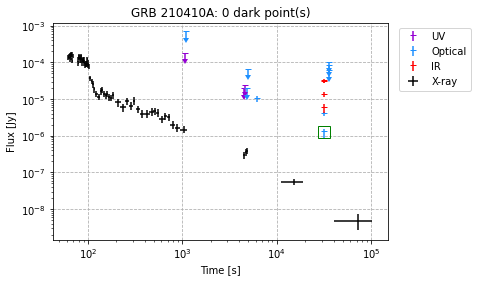

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
20,210323A,1038247,Gemini North,GMOS,r,6224.52,62208.0,24.6,0.2,GCN 29720,0.131,0.297948,24.6 ± 0.2,6.905664110119469e-07 ± 1.272070338974806e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


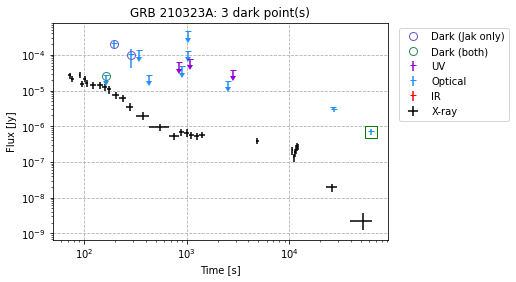

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
44,201221D,1014037,NOT,ALFOSC,r,6141.12,6012.0,23.1,0.3,GCN 29117,0.02,0.046046,23.1 ± 0.3,2.1799401461112093e-06 ± 6.023397220865919e-07
48,201221D,1014037,Discovery,LMI,r,6141.12,36396.0,23.9,0,GCN 29128,0.02,0.046046,23.9 ± 0.0,1.0433849533910372e-06 ± 0.0
49,201221D,1014037,Discovery,LMI,i,7457.89,36396.0,23.7,0,GCN 29128,0.02,0.034223,23.7 ± 0.0,1.2408392388138238e-06 ± 0.0


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


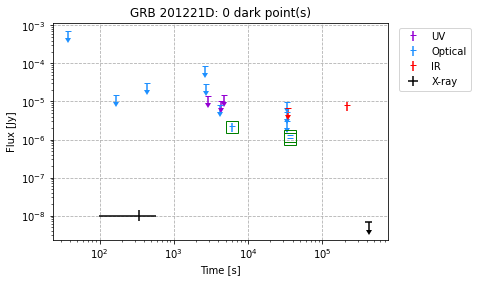

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
94,201006A,998907,Discovery,LMI,i,7457.89,124416.0,23.8,3-sigma,GCN 28572,1.27,2.173172,"23.8 (+inf, -0.0)","8.1151186884704e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


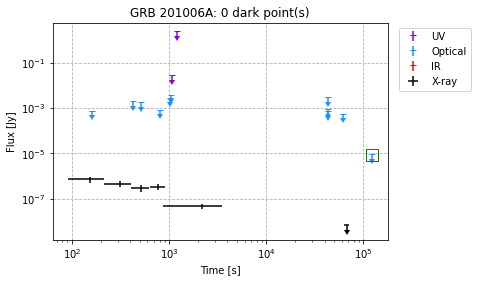

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
139,200522A,973628,Gemini North,GMOS,r,6224.52,269568.0,26.00,0.04,arXiv:2012.00026,0.03,0.068232,26.0 ± 0.04,1.5392855619967717e-07 ± 5.670937582263566e-09
140,200522A,973628,Hubble,WFC3,F125W,12364.65,299808.0,24.90,0.08,arXiv:2012.00026,0.03,0.021679,24.9 ± 0.08,4.0616070630785857e-07 ± 2.992702680654105e-08
128,200522A,973628,Hubble,WFC3,F125W,12364.65,304128.0,24.53,0.15,2021ApJ...906..127F,0.03,0.021679,24.53 ± 0.15,5.710812555030189e-07 ± 7.889779114857451e-08
144,200522A,973628,Hubble,WFC3,NaN,15279.08,311040.0,23.70,NaN,GCN 27826,0.03,0.015330,"23.7 (+nan, -nan)","1.2194343881858644e-06 (+nan, -nan)"
145,200522A,973628,Hubble,WFC3,F125W,12364.65,311040.0,23.80,0.3,GCN 27827,0.03,0.021679,23.8 ± 0.3,1.1186594754812014e-06 ± 3.090970358855463e-07
141,200522A,973628,Hubble,WFC3,F160W,15279.08,311904.0,24.71,0.07,arXiv:2012.00026,0.03,0.015330,24.71 ± 0.07,4.81014798821612e-07 ± 3.101217014773287e-08
129,200522A,973628,Hubble,WFC3,F160W,15279.08,316224.0,24.61,0.15,2021ApJ...906..127F,0.03,0.015330,24.61 ± 0.15,5.274222389300992e-07 ± 7.286607510443941e-08
142,200522A,973628,Hubble,WFC3,F125W,12364.65,1410048.0,27.20,3-sigma,arXiv:2012.00026,0.03,0.021679,"27.2 (+inf, -0.0)","4.883125719330247e-08 (+0.0, -inf)"
130,200522A,973628,Hubble,WFC3,F125W,12364.65,1415232.0,27.50,3-sigma,2021ApJ...906..127F,0.03,0.021679,"27.5 (+inf, -0.0)","3.704229666732184e-08 (+0.0, -inf)"
146,200522A,973628,Hubble,WFC3,NaN,12364.65,1416960.0,26.80,<3-sigma,GCN 27904,0.03,0.021679,"26.8 (+inf, -0.0)","7.058264120272258e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


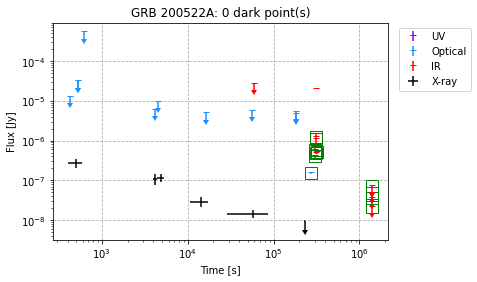

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
196,191031D,932608,MMT,Binospec,r,NaN,15516.0,23.50,3-sigma,GCN 26134,0.08,NaN,"23.5 (+inf, -0.0)","nan (+nan, -nan)"
1403,191031D,NaN,MMT,Binospec,r,6122.940,15552.0,24.10,3-sigma,Rastinejad,0.08,0.185232,"24.1 (+inf, -0.0)","9.865497528567421e-07 (+0.0, -inf)"
1407,191031D,NaN,HJT,RATIR,i,7531.293,18144.0,23.10,3-sigma,Rastinejad,0.08,0.134263,"23.1 (+inf, -0.0)","2.364456394798117e-06 (+0.0, -inf)"
179,191031D,932608,Johnson,RATIR,i,7531.290,18252.0,23.17,3-sigma,GCN 26121,0.08,0.134263,"23.17 (+inf, -0.0)","2.2168246563739915e-06 (+0.0, -inf)"
1405,191031D,NaN,MMT,Binospec,r,6122.940,102816.0,24.40,3-sigma,Rastinejad,0.08,0.185232,"24.4 (+inf, -0.0)","7.483745191677094e-07 (+0.0, -inf)"
1408,191031D,NaN,Gemini-N,GMOS,r,6224.520,112320.0,24.80,3-sigma,Rastinejad,0.08,0.181953,"24.8 (+inf, -0.0)","5.161874492394049e-07 (+0.0, -inf)"
197,191031D,932608,Gemini North,GMOS,r,6224.520,112320.0,25.00,NaN,GCN 26147,0.08,0.181953,"25.0 (+nan, -nan)","4.293460193752377e-07 (+nan, -nan)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


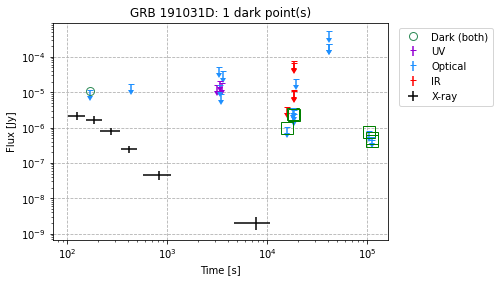

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
207,190719C,915381,NOT,ALFOSC,NaN,6141.12,129686.4,23.03,0.12,GCN 25144,0.04,0.092092,23.03 ± 0.12,2.4258441175067434e-06 ± 2.681142001391195e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


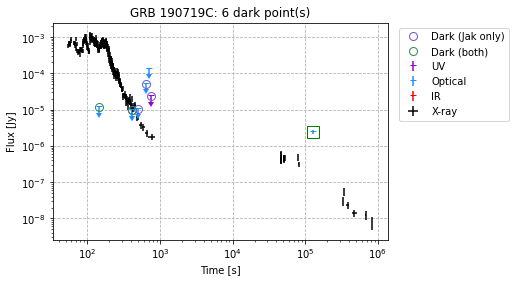

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


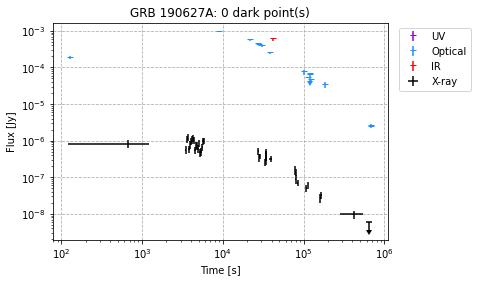

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1400,181126A,NaN,Gemini-N,GMOS,z,9571.59,15552.0,25.3,3-sigma,Rastinejad,0.07,0.078140,"25.3 (+inf, -0.0)","2.9599353322133564e-07 (+0.0, -inf)"
1401,181126A,NaN,Keck I,MOSFIRE,Ks,21354.70,15552.0,23.6,3-sigma,Rastinejad,0.07,0.022192,"23.6 (+inf, -0.0)","1.3455604272546054e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


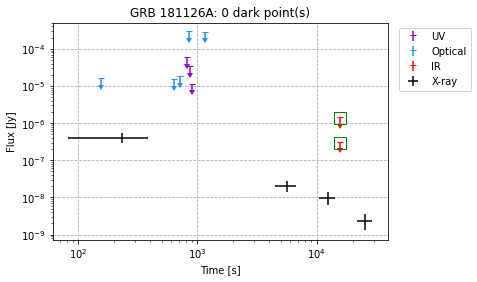

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
283,181123B,873186,Gemini North,GMOS,i,7713.830,32832.0,25.10,0.39,2020ApJ...898L..32P,0.03,0.048439,25.1 ± 0.39,3.4625970047727575e-07 ± 1.2437761824127513e-07
282,181123B,873186,Gemini North,GMOS,i,7713.830,33120.0,23.32,0.25,GCN 23439,0.03,0.048439,23.32 ± 0.25,1.7840291615019164e-06 ± 4.1078789527409804e-07
287,181123B,873186,Keck,MOSFIRE,J,12431.167,33120.0,23.30,3-sigma,GCN 23461,0.03,0.021449,"23.3 (+inf, -0.0)","1.7725800080287376e-06 (+0.0, -inf)"
285,181123B,873186,Keck,MOSFIRE,J,12431.167,37152.0,23.20,inf,2020ApJ...898L..32P,0.03,0.021449,"23.2 (+inf, -0.0)","1.943595329722827e-06 (+0.0, -inf)"
284,181123B,873186,MMT,MMIRS,J,12452.990,196128.0,23.30,inf,2020ApJ...898L..32P,0.03,0.021373,"23.3 (+inf, -0.0)","1.77245673911448e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


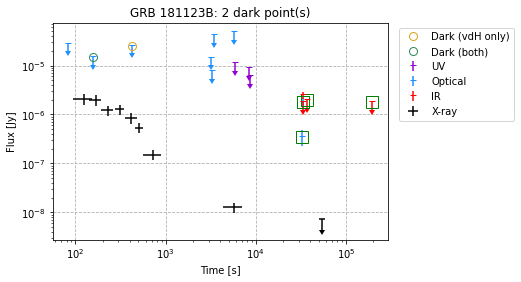

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1395,180805B,NaN,ESO,HAWK-I,J,12522.31,60480.0,24.4,3-sigma,Rastinejad,0.02,0.014117,"24.4 (+inf, -0.0)","6.39253659007889e-07 (+0.0, -inf)"
1397,180805B,NaN,NTT,EFOSC2,i,7944.87,63936.0,25.0,3-sigma,Rastinejad,0.02,0.030951,"25.0 (+inf, -0.0)","3.7359968177692304e-07 (+0.0, -inf)"
1394,180805B,NaN,Magellan-Baade,IMACS,r,6463.84,69120.0,24.2,3-sigma,Rastinejad,0.02,0.042990,"24.2 (+inf, -0.0)","7.892638862875304e-07 (+0.0, -inf)"
1396,180805B,NaN,ESO,FORS2,R,6425.70,70848.0,25.7,3-sigma,Rastinejad,0.02,0.043387,"25.7 (+inf, -0.0)","1.9832654704498356e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


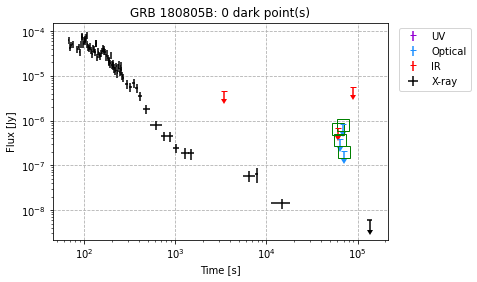

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1393,180727A,NaN,Magellan-Clay,LDSS3,i,7606.23,143424.0,24.2,3-sigma,Rastinejad,0.02,0.033035,"24.2 (+inf, -0.0)","7.820601527779771e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


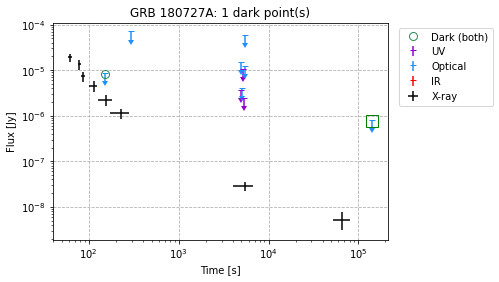

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
344,180418A,826428,La Silla,GROND,g',4504.49,67320.0,23.60,0.14,GCN 22662,0.02,0.069583,23.6 ± 0.14,1.4055921121436194e-06 ± 1.8124374487810715e-07
345,180418A,826428,La Silla,GROND,r',6097.98,67320.0,23.24,0.13,GCN 22662,0.02,0.046668,23.24 ± 0.13,1.9173147268727545e-06 ± 2.2956857605110807e-07
352,180418A,826428,Johnson,RATIR,r,6149.31,85608.0,23.63,0.22,GCN 22664,0.02,0.045928,23.63 ± 0.22,1.3378189033322842e-06 ± 2.7107888402659333e-07
353,180418A,826428,Johnson,RATIR,i,7531.29,85608.0,23.14,0.16,GCN 22664,0.02,0.033566,23.14 ± 0.16,2.0770766450139916e-06 ± 3.060893260681794e-07
528,180418A,826428,Gemini North,GMOS,r,6224.52,86400.0,23.86,0.13,2021ApJ...912...95R,0.02,0.045488,23.86 ± 0.13,1.0819857645037267e-06 ± 1.2955094319325845e-07
529,180418A,826428,Gemini North,GMOS,i,7713.83,96768.0,23.85,0.08,2021ApJ...912...95R,0.02,0.032293,23.85 ± 0.08,1.078806072312872e-06 ± 7.948936897085041e-08
530,180418A,826428,Gemini North,GMOS,z,9571.59,98496.0,23.37,0.29,2021ApJ...912...95R,0.02,0.022326,23.37 ± 0.29,1.6632461512941445e-06 ± 4.442528320981555e-07
531,180418A,826428,Gemini North,GMOS,g,4647.53,101952.0,24.50,0.31,2021ApJ...912...95R,0.02,0.067285,24.5 ± 0.31,6.122663740405936e-07 ± 1.7481463280011607e-07


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


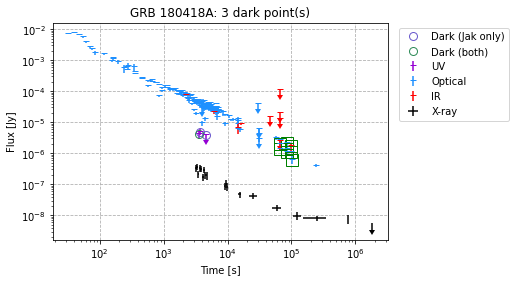

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
548,180402A,821103,Johnson,RATIR,r,6149.31,3222.0,23.3,3-sigma,GCN 22582,0.77,1.768216,"23.3 (+inf, -0.0)","8.857533477261686e-06 (+0.0, -inf)"
549,180402A,821103,Johnson,RATIR,i,7531.29,3222.0,23.3,3-sigma,GCN 22582,0.77,1.292279,"23.3 (+inf, -0.0)","5.713967703558705e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


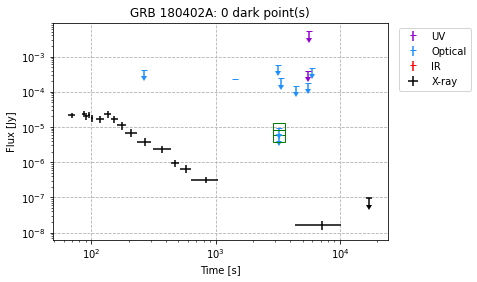

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
599,170822A,768939,Johnson,RATIR,r,6149.31,93294.0,23.37,3-sigma,GCN 21655,0.17,0.390385,"23.37 (+inf, -0.0)","2.334427674242859e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


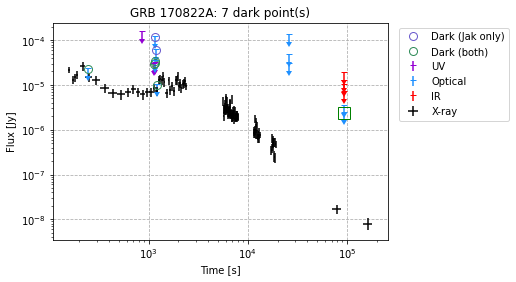

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
614,170728B,765130,Swift,UVOT,UVW1,2684.14,9965.0,23.11,3-sigma,GCN 21399,0.03,0.172156,"23.110000000000003 (+inf, -0.0)","2.425987494208703e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


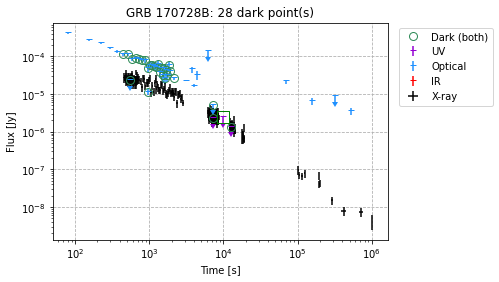

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1379,170428A,NaN,MMT,MMTCam,i,7591.2,265248.0,23.7,3-sigma,Rastinejad,0.06,0.099424,"23.7 (+inf, -0.0)","1.3176369133191583e-06 (+0.0, -inf)"
1380,170428A,NaN,MMT,MMTCam,i,7591.2,352512.0,24.4,3-sigma,Rastinejad,0.06,0.099424,"24.4 (+inf, -0.0)","6.915056820103782e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


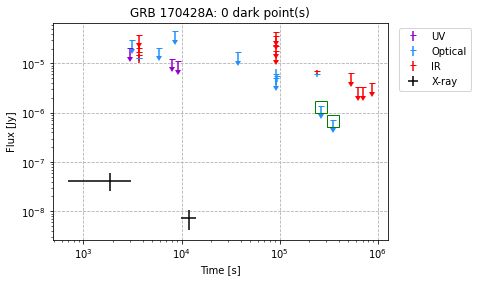

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1378,170127B,NaN,NOT,ALFSOC,r,6330.81,16416.0,23.4,3-sigma,Rastinejad,0.02,0.044047,"23.4 (+inf, -0.0)","1.6506123351826636e-06 (+0.0, -inf)"
711,170127B,735331,NOT,ALFOSC,r,6141.12,17028.0,23.5,?,GCN 20549,0.02,0.046046,"23.5 (+inf, -0.0)","1.5081501078292918e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


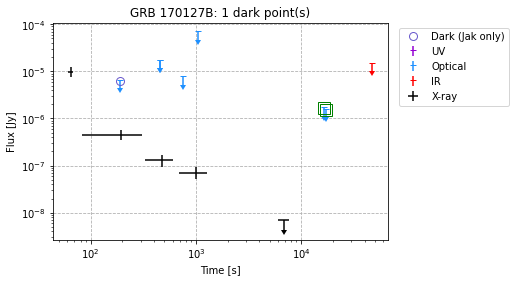

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
733,161104A,720568,Swift,UVOT,UVM2,2245.78,4879.0,23.39,3-sigma,GCN 20130,0.02,0.155467,"23.39 (+inf, -0.0)","1.8459202303851659e-06 (+0.0, -inf)"
736,161104A,720568,Gemini South,GMOS,r,6244.66,61200.0,24.60,NaN,GCN 20137,0.02,0.046656,"24.6 (+nan, -nan)","5.478838525444566e-07 (+nan, -nan)"
735,161104A,720568,La Silla,GROND,r',6097.98,64800.0,24.10,0.1,GCN 20132,0.02,0.046668,24.1 ± 0.1,8.683471997142399e-07 ± 7.99777327042053e-08


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


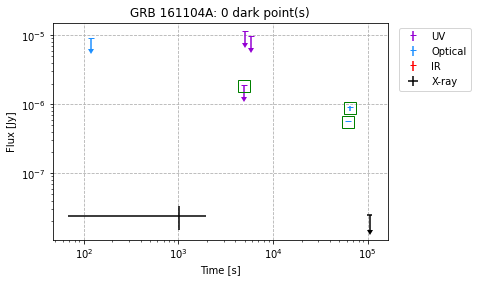

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


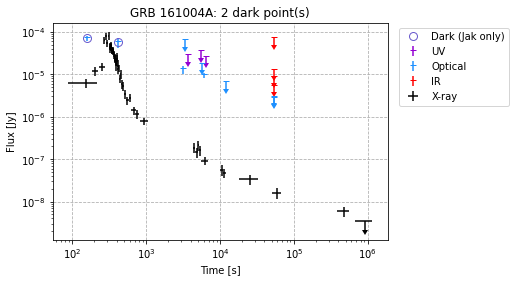

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
757,160927A,713782,NOT,ALFOSC,r,6141.12,12816.0,23.07,0.1,GCN 19960,0.08,0.184183,23.07 ± 0.1,2.5450688249067958e-06 ± 2.3440950147497043e-07
756,160927A,713782,La Silla,GROND,r',6097.98,20088.0,23.90,0.4,GCN 19959,0.08,0.186672,23.9 ± 0.4,1.1876675362975848e-06 ± 4.3755289032188544e-07
768,160927A,713782,Magellan/Baade,IMACS,r,6463.84,21384.0,23.84,0.21,GCN 19964,0.08,0.171960,23.84 ± 0.21,1.2382552547123352e-06 ± 2.394997996290621e-07
769,160927A,713782,GTC,OSIRIS,r,6350.01,95472.0,25.30,0.2,GCN 20004,0.08,0.175407,25.3 ± 0.2,3.237344710251509e-07 ± 5.963409336566604e-08


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


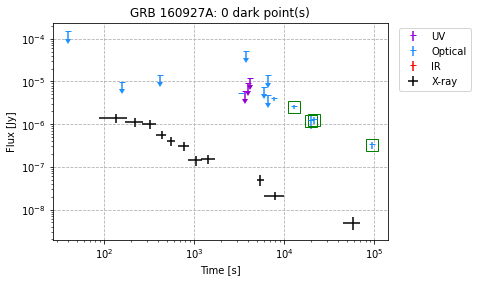

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
795,160821B,709357,TNG,DOLoRes,g,4672.08,82080.000,24.02,0.16,2019ApJ...883...48L,0.05,0.167420,24.02 ± 0.16,1.0447060306834353e-06 ± 1.5395357010001014e-07
820,160821B,709357,GTC,CIRCE,H,16181.36,82944.000,23.83,0.35,2019ApJ...883...48L,0.05,0.023414,23.83 ± 0.35,1.0899130102335851e-06 ± 3.513464430033768e-07
802,160821B,709357,WHT,ACAM,r,6256.18,91584.000,23.82,0.07,2019ApJ...883...48L,0.05,0.115413,23.82 ± 0.07,1.1972678591560749e-06 ± 7.719071149478285e-08
829,160821B,709357,WHT,ACAM,r,6256.18,92448.000,23.83,0.25,2019MNRAS.489.2104T,0.05,0.115413,23.83 ± 0.25,1.1862912414452199e-06 ± 2.7315365285011635e-07
814,160821B,709357,WHT,ACAM,z,9103.78,93312.000,23.60,0.15,2019ApJ...883...48L,0.05,0.060915,23.6 ± 0.15,1.394415220714856e-06 ± 1.926455820397218e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,160821B,709357,Hubble,WFC3,NaN,11203.65,2002826.304,28.00,inf,2018ApJ...857..128J,0.05,0.043824,"28.0 (+inf, -0.0)","2.385371202170175e-08 (+0.0, -inf)"
808,160821B,709357,Hubble,WFC3,F606W,5780.85,2004480.000,27.34,inf,2019ApJ...883...48L,0.05,0.126412,"27.34 (+inf, -0.0)","4.727059888759895e-08 (+0.0, -inf)"
855,160821B,709357,Hubble,WFC3,F160W,15279.08,2005948.800,25.70,inf,2019MNRAS.489.2104T,0.05,0.025551,"25.7 (+inf, -0.0)","1.9509519086297314e-07 (+0.0, -inf)"
823,160821B,709357,Hubble,WFC3,F160W,15279.08,2007072.000,27.21,inf,2019ApJ...883...48L,0.05,0.025551,"27.21 (+inf, -0.0)","4.8556409354100935e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


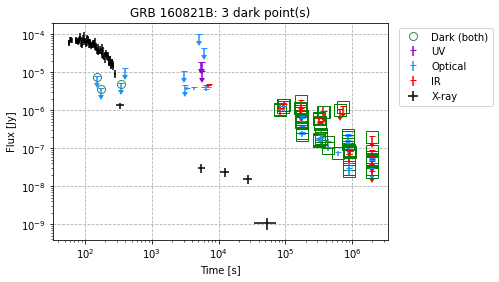

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
916,160624A,701288,Gemini North,GMOS,r,6224.52,1900.8,25.1,3-sigma,arXiv:2012.00026,0.07,0.159209,"25.1 (+inf, -0.0)","3.834509267773626e-07 (+0.0, -inf)"
917,160624A,701288,Gemini North,GMOS,NaN,6224.52,2760.0,25.5,inf,GCN 19565,0.07,0.159209,"25.5 (+inf, -0.0)","2.6528322697214867e-07 (+0.0, -inf)"
918,160624A,701288,Gemini North,GMOS,NaN,6224.52,3801.6,25.9,3-sigma,arXiv:2012.00026,0.07,0.159209,"25.9 (+inf, -0.0)","1.8353115248465092e-07 (+0.0, -inf)"
1370,160624A,NaN,Gemini-N,GMOS,r,6224.52,4320.0,24.8,3-sigma,Rastinejad,0.07,0.159209,"24.8 (+inf, -0.0)","5.054867681299588e-07 (+0.0, -inf)"
1369,160624A,NaN,UKIRT,WFCAM,J,12483.00,90720.0,23.4,3-sigma,Rastinejad,0.07,0.049629,"23.4 (+inf, -0.0)","1.6591208712494075e-06 (+0.0, -inf)"
919,160624A,701288,Gemini North,GMOS,NaN,6224.52,94176.0,25.8,3-sigma,arXiv:2012.00026,0.07,0.159209,"25.8 (+inf, -0.0)","2.0123790701244948e-07 (+0.0, -inf)"
924,160624A,701288,Hubble,ACS/WFC,F606W,5810.77,288576.0,27.5,3-sigma,arXiv:2012.00026,0.07,0.176015,"27.5 (+inf, -0.0)","4.2700445461292275e-08 (+0.0, -inf)"
1372,160624A,NaN,HST,ACS,F 606W,5810.77,290304.0,27.7,3-sigma,Rastinejad,0.07,0.176015,"27.7 (+inf, -0.0)","3.551668354464839e-08 (+0.0, -inf)"
925,160624A,701288,Hubble,WFC3,F125W,12364.65,368928.0,27.2,3-sigma,arXiv:2012.00026,0.07,0.050585,"27.2 (+inf, -0.0)","5.014875025985679e-08 (+0.0, -inf)"
1373,160624A,NaN,HST,WFC3,F 125W,12364.65,368928.0,27.5,3-sigma,Rastinejad,0.07,0.050585,"27.5 (+inf, -0.0)","3.804171736286623e-08 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


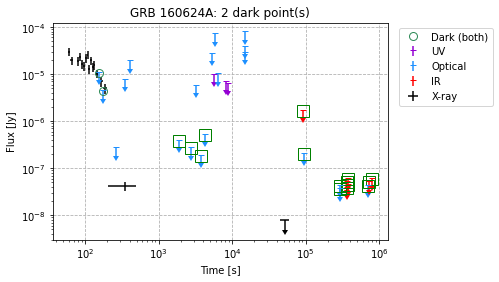

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
948,160601A,688452,NOT,ALFOSC,r,6330.81000,48600.0,23.36,0.1,GCN 19488,0.02,0.044047,23.36 ± 0.1,1.7125572012517397e-06 ± 1.577323473000744e-07
953,160601A,688452,Gemini North,GMOS,r,6224.52000,55080.0,23.69,0.05,GCN 19492,0.02,0.045488,23.69 ± 0.05,1.2653816926792769e-06 ± 5.827298045021751e-08
1366,160601A,NaN,DCT,LMI,r,6100.36312,138240.0,25.00,3-sigma,Rastinejad,0.02,0.046634,"25.0 (+inf, -0.0)","3.7903530319510593e-07 (+0.0, -inf)"
965,160601A,688452,Discovery,LMI,r,6141.12000,138240.0,25.00,inf,GCN 19497,0.02,0.046046,"25.0 (+inf, -0.0)","3.788301792536111e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


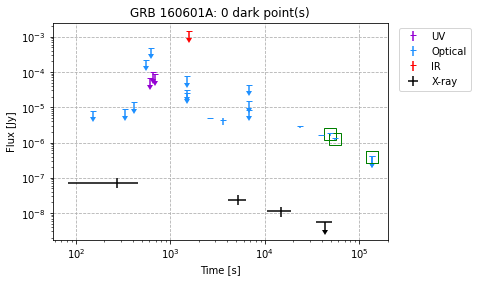

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
990,160411A,682339,La Silla,GROND,g',4504.49,27900.0,23.7,UL,GCN 19292,0.02,0.069583,"23.7 (+inf, -0.0)","1.2819152419881508e-06 (+0.0, -inf)"
991,160411A,682339,La Silla,GROND,r',6097.98,27900.0,23.9,UL,GCN 19292,0.02,0.046668,"23.9 (+inf, -0.0)","1.0439829551160587e-06 (+0.0, -inf)"
992,160411A,682339,La Silla,GROND,i',7604.74,27900.0,23.1,UL,GCN 19292,0.02,0.033045,"23.1 (+inf, -0.0)","2.1539934621973035e-06 (+0.0, -inf)"
1359,160411A,NaN,Gemini-S,GMOS,i,7719.34,29376.0,23.3,0.2,Rastinejad,0.02,0.032254,23.3 ± 0.2,1.7903077386263776e-06 ± 3.2978687286663824e-07
1360,160411A,NaN,ESO,MPG,g 0,4504.49,29376.0,23.6,3-sigma,Rastinejad,0.02,0.069583,"23.6 (+inf, -0.0)","1.4055921121436194e-06 (+0.0, -inf)"
1361,160411A,NaN,ESO,MPG,r 0,6097.98,29376.0,23.8,3-sigma,Rastinejad,0.02,0.046668,"23.8 (+inf, -0.0)","1.1447045474298854e-06 (+0.0, -inf)"
1362,160411A,NaN,ESO,MPG,i0,7604.74,29376.0,23.1,3-sigma,Rastinejad,0.02,0.033045,"23.1 (+inf, -0.0)","2.1539934621973035e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


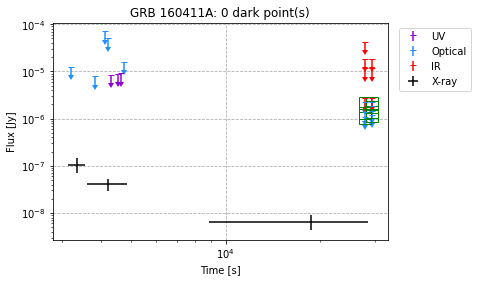

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1358,160410A,NaN,NOT,ALFSOC,r,6330.81,145152.0,25.0,3-sigma,Rastinejad,0.02,0.044047,"25.0 (+inf, -0.0)","3.7813344059294365e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


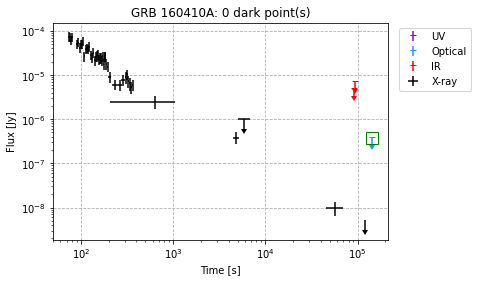

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
997,160408A,682059,Gemini North,GMOS,r,6224.52,3480.0,24.5,NaN,GCN 19262,0.03,0.068232,"24.5 (+nan, -nan)","6.128006197603842e-07 (+nan, -nan)"
1354,160408A,NaN,Gemini-N,GMOS,r,6224.52,4320.0,24.8,0.1,Rastinejad,0.03,0.068232,24.8 ± 0.1,4.6485680811421213e-07 ± 4.281489426962314e-08
1008,160408A,682059,Yunnan,GMG,R,6695.58,32400.0,23.3,UL,GCN 19270,0.03,0.060820,"23.3 (+inf, -0.0)","1.8380368354096547e-06 (+0.0, -inf)"
1355,160408A,NaN,Gemini-N,GMOS,r,6224.52,83808.0,25.5,3-sigma,Rastinejad,0.03,0.068232,"25.5 (+inf, -0.0)","2.439603208462359e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


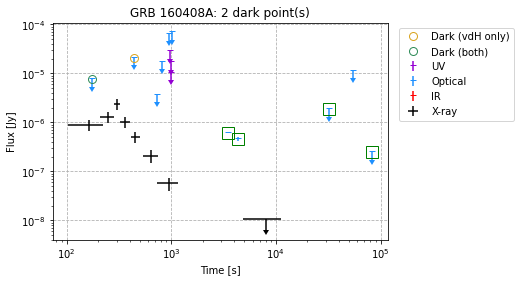

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1344,160303A,NaN,HJT,RATIR,r,6149.311,75168.0,23.7,3-sigma,Rastinejad,0.02,0.045928,"23.7 (+inf, -0.0)","1.2542881592525288e-06 (+0.0, -inf)"
1345,160303A,NaN,HJT,RATIR,i,7531.293,75168.0,23.9,3-sigma,Rastinejad,0.02,0.033566,"23.9 (+inf, -0.0)","1.0314602927868264e-06 (+0.0, -inf)"
1350,160303A,NaN,ESO,MPG,i0,7604.740,149472.0,24.3,3-sigma,Rastinejad,0.02,0.033045,"24.3 (+inf, -0.0)","7.132542708035616e-07 (+0.0, -inf)"
1351,160303A,NaN,ESO,MPG,z 0,8929.330,149472.0,24.4,3-sigma,Rastinejad,0.02,0.025230,"24.4 (+inf, -0.0)","6.45829811473263e-07 (+0.0, -inf)"
1352,160303A,NaN,MMT,MMTCam,r,6122.940,336960.0,25.6,3-sigma,Rastinejad,0.02,0.046308,"25.6 (+inf, -0.0)","2.1804665804175062e-07 (+0.0, -inf)"
1353,160303A,NaN,MMT,MMTCam,i,7591.200,934848.0,24.5,3-sigma,Rastinejad,0.02,0.033141,"24.5 (+inf, -0.0)","5.933114781977335e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


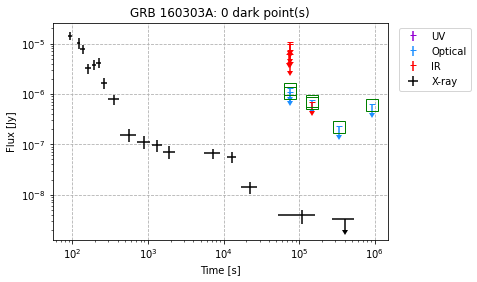

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


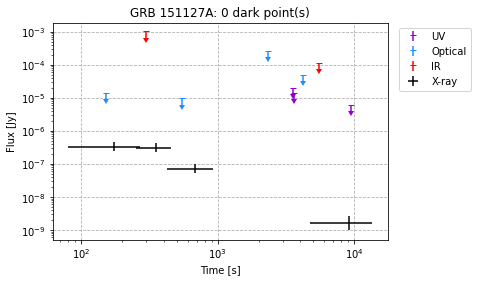

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1337,150831A,NaN,ESO,MPG,g 0,4504.49,45792.0,24.5,3-sigma,Rastinejad,0.11,0.382705,"24.5 (+inf, -0.0)","8.186685224650939e-07 (+0.0, -inf)"
1338,150831A,NaN,ESO,MPG,r 0,6097.98,45792.0,24.2,3-sigma,Rastinejad,0.11,0.256673,"24.2 (+inf, -0.0)","9.609385678355798e-07 (+0.0, -inf)"
1339,150831A,NaN,ESO,MPG,i0,7604.74,45792.0,23.8,3-sigma,Rastinejad,0.11,0.181749,"23.8 (+inf, -0.0)","1.2963610510561376e-06 (+0.0, -inf)"
1340,150831A,NaN,ESO,MPG,z 0,8929.33,45792.0,23.6,3-sigma,Rastinejad,0.11,0.138763,"23.6 (+inf, -0.0)","1.4980674395847475e-06 (+0.0, -inf)"
1066,150831A,653838,La Silla,GROND,g',4504.49,46800.0,24.9,UL,GCN 18219,0.11,0.382705,"24.9 (+inf, -0.0)","5.663802387577992e-07 (+0.0, -inf)"
1067,150831A,653838,La Silla,GROND,r',6097.98,46800.0,24.5,UL,GCN 18219,0.11,0.256673,"24.5 (+inf, -0.0)","7.289464485407323e-07 (+0.0, -inf)"
1068,150831A,653838,La Silla,GROND,i',7604.74,46800.0,23.8,UL,GCN 18219,0.11,0.181749,"23.8 (+inf, -0.0)","1.2963610510561376e-06 (+0.0, -inf)"
1069,150831A,653838,La Silla,GROND,z',8929.33,46800.0,23.8,UL,GCN 18219,0.11,0.138763,"23.8 (+inf, -0.0)","1.246038222915132e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


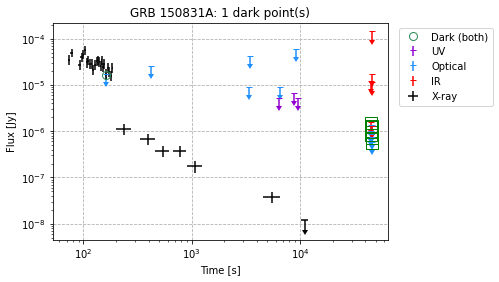

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1216,150424A,638946,Swift,UVOT,UVW2,2085.73,3.146000e+03,23.63,UL,2017A&A...607A..84K,0.06,0.517216,"23.63 (+inf, -0.0)","2.0649652638170865e-06 (+0.0, -inf)"
1225,150424A,638946,Swift,UVOT,UVM2,2245.78,3.376000e+03,23.39,UL,2017A&A...607A..84K,0.06,0.466400,"23.39 (+inf, -0.0)","2.4580249714831e-06 (+0.0, -inf)"
1226,150424A,638946,Swift,UVOT,UVM2,2245.78,7.240600e+04,23.59,UL,2017A&A...607A..84K,0.06,0.466400,"23.59 (+inf, -0.0)","2.0444961197453264e-06 (+0.0, -inf)"
1210,150424A,638946,Swift,UVOT,UVW1,2684.14,9.265700e+04,23.61,UL,2017A&A...607A..84K,0.06,0.344312,"23.610000000000003 (+inf, -0.0)","1.793704371791493e-06 (+0.0, -inf)"
1125,150424A,638946,La Silla,GROND,g′,4504.49,1.561230e+05,23.32,0.1,2017A&A...607A..84K,0.06,0.208748,23.32 ± 0.1,2.067880491987826e-06 ± 1.9045883179777448e-07
1135,150424A,638946,La Silla,GROND,r′,6097.98,1.565820e+05,23.08,0.07,2017A&A...607A..84K,0.06,0.140004,23.08 ± 0.07,2.42118361624424e-06 ± 1.560994764606313e-07
1145,150424A,638946,La Silla,GROND,i′,7604.74,1.565820e+05,23.03,0.13,2017A&A...607A..84K,0.06,0.099136,23.03 ± 0.13,2.4416344533739523e-06 ± 2.9234769693373545e-07
1227,150424A,638946,Swift,UVOT,UVM2,2245.78,1.731860e+05,23.99,UL,2017A&A...607A..84K,0.06,0.466400,"23.990000000000002 (+inf, -0.0)","1.4144457355634012e-06 (+0.0, -inf)"
1211,150424A,638946,Swift,UVOT,UVW1,2684.14,1.779630e+05,23.31,UL,2017A&A...607A..84K,0.06,0.344312,"23.310000000000002 (+inf, -0.0)","2.3645628750922185e-06 (+0.0, -inf)"
1241,150424A,638946,Swift,UVOT,White,3885.68,3.355420e+05,23.10,UL,2017A&A...607A..84K,0.06,0.239055,"23.1 (+inf, -0.0)","2.6040435269768633e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


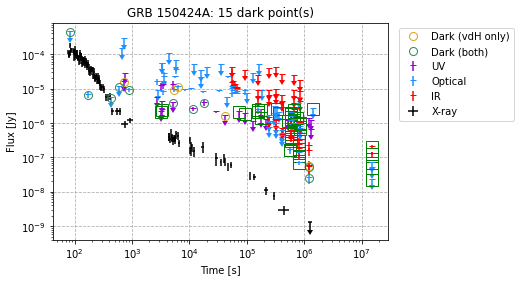

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1269,150423A,638808,La Silla,GROND,g',4504.490,1440.0,23.20,0.2,GCN 17729,0.03,0.104374,23.2 ± 0.2,2.0978568129368264e-06 ± 3.8643950597634684e-07
1270,150423A,638808,La Silla,GROND,r',6097.980,1440.0,23.10,0.2,GCN 17729,0.03,0.070002,23.1 ± 0.2,2.228573631727364e-06 ± 4.1051843384440247e-07
1296,150423A,638808,Swift,UVOT,UVW2,2085.730,3432.0,23.33,3-sigma,GCN 17739,0.03,0.258608,"23.330000000000002 (+inf, -0.0)","2.1452084535415394e-06 (+0.0, -inf)"
1277,150423A,638808,La Silla,GROND,g',4504.490,3480.0,23.20,0.2,GCN 17732,0.03,0.104374,23.2 ± 0.2,2.0978568129368264e-06 ± 3.8643950597634684e-07
1278,150423A,638808,La Silla,GROND,r',6097.980,3480.0,23.10,0.2,GCN 17732,0.03,0.070002,23.1 ± 0.2,2.228573631727364e-06 ± 4.1051843384440247e-07
1332,150423A,NaN,Magellan,IMACS,i,7655.050,8640.0,23.60,0.1,Rastinejad,0.03,0.049052,23.6 ± 0.1,1.3792627569227324e-06 ± 1.2703479453648615e-07
1284,150423A,638808,Johnson,RATIR,r,6149.310,14958.0,23.77,0.23,GCN 17736,0.03,0.068892,23.77 ± 0.23,1.2011102354128455e-06 ± 2.5444058412558523e-07
1285,150423A,638808,Johnson,RATIR,i,7531.290,14958.0,23.62,0.26,GCN 17736,0.03,0.050349,23.62 ± 0.26,1.355706440581289e-06 ± 3.246494618180834e-07
1300,150423A,638808,La Palma,William Herschel Telescope/ACAM,g,4762.280,56822.0,25.30,5-sigma,GCN 17747,0.03,0.097992,"25.3 (+inf, -0.0)","3.0145535989058876e-07 (+0.0, -inf)"
1333,150423A,NaN,WHT,ACAM,g,4762.280,57888.0,25.20,3-sigma,Rastinejad,0.03,0.097992,"25.2 (+inf, -0.0)","3.305392292305281e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


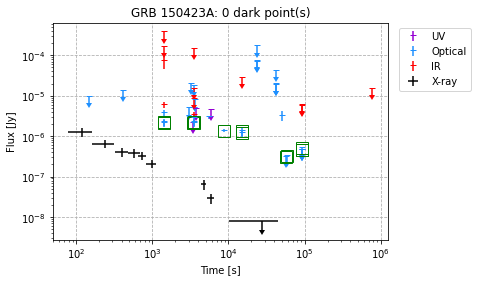

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1328,150120A,NaN,Gemini-N,GMOS,i,7713.83,6912.0,26.0,3-sigma,Rastinejad,0.1,0.161464,"26.0 (+inf, -0.0)","1.677304514639257e-07 (+0.0, -inf)"
1329,150120A,NaN,Gemini-N,GMOS,r,6224.52,6912.0,26.1,3-sigma,Rastinejad,0.1,0.227441,"26.1 (+inf, -0.0)","1.6255590066721992e-07 (+0.0, -inf)"
1331,150120A,NaN,Gemini-N,GMOS,r,6224.52,186624.0,25.7,3-sigma,Rastinejad,0.1,0.227441,"25.7 (+inf, -0.0)","2.3496476379382422e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


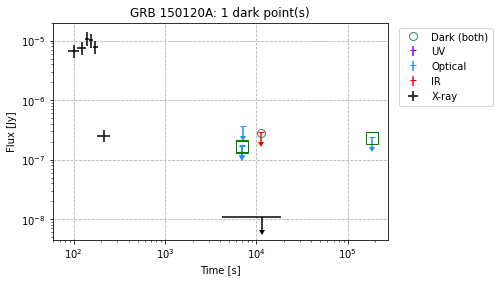

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1326,141212A,NaN,Gemini-N,GMOS,i,7713.83,59616.0,25.2,3-sigma,Rastinejad,0.09,0.145318,"25.2 (+inf, -0.0)","3.452656309860888e-07 (+0.0, -inf)"
1327,141212A,NaN,Gemini-N,GMOS,i,7713.83,151200.0,25.2,3-sigma,Rastinejad,0.09,0.145318,"25.2 (+inf, -0.0)","3.452656309860888e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


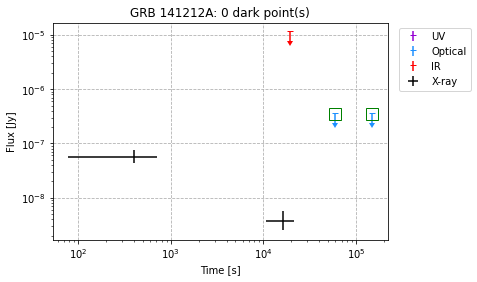

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1315,130912A,NaN,WHT,ACAM,g,4762.280,72576.0,24.1,3-sigma,Rastinejad,0.28,0.914591,"24.1 (+inf, -0.0)","1.9313575700111904e-06 (+0.0, -inf)"
1317,130912A,NaN,HJT,RATIR,r,6149.311,89856.0,23.3,3-sigma,Rastinejad,0.28,0.642988,"23.3 (+inf, -0.0)","3.1421092304797613e-06 (+0.0, -inf)"
1318,130912A,NaN,HJT,RATIR,i,7531.293,89856.0,23.3,3-sigma,Rastinejad,0.28,0.469919,"23.3 (+inf, -0.0)","2.6791310634162193e-06 (+0.0, -inf)"
1323,130912A,NaN,Magellan,FourStar,J,12287.960,1029888.0,23.7,3-sigma,Rastinejad,0.28,0.205050,"23.7 (+inf, -0.0)","1.4522660002839714e-06 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


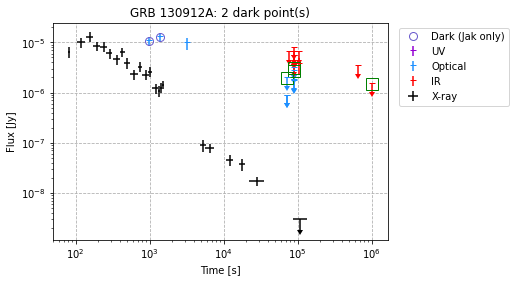

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
1312,130822A,NaN,Gemini-N,GMOS,i,7713.83,76032.0,24.5,3-sigma,Rastinejad,0.03,0.048439,"24.5 (+inf, -0.0)","6.017303944519206e-07 (+0.0, -inf)"


,GRB,t_o,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark


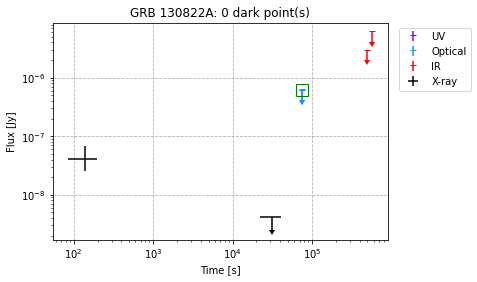

In [25]:
for grb in all_optical[(all_optical["Magnitude"]>=23) & (all_optical["Time (s)"]>=1000) & (all_optical["GRB"].isin(xrt_data["GRB"]))]["GRB"].unique():
    fig, ax = plt.subplots()

    subset = all_optical.loc[(all_optical["GRB"]==grb)].copy()
    dark_points = close_times[close_times["GRB"]==grb]
    of_interest = subset[(subset["Magnitude"]>=23) & (subset["Time (s)"]>=1000) & ~(subset["Time (s)"].isin(results.loc[results["GRB"]==grb,"t_o"]))]
    display(of_interest)
    display(results[(results["GRB"]==grb) & results["t_o"].isin(of_interest["Time (s)"])])

    subset.loc[:,"band"] = ["UV" if wavelength<3000 else "IR" if wavelength>8000 else None if pd.isna(wavelength) else "Optical" for wavelength in subset["λ_eff"]]
    bands = {"UV":["darkviolet","$\lambda<3000$ Å"],"Optical":["dodgerblue","$\lambda<3000$ Å"],"IR":"red"}
    for band,info in bands.items():
        subsubset = subset[subset["band"]==band]
        neg_err = [0.3*flux.value if np.isinf(flux.minus) else flux.minus for flux in subsubset["Flux (Jy)"]]
        pos_err = [0.3*flux.value if np.isinf(flux.plus) else flux.plus for flux in subsubset["Flux (Jy)"]]
        ax.errorbar(subsubset["Time (s)"],[flux.value for flux in subsubset["Flux (Jy)"]],
                    marker="$—$",linestyle="",color=info[0],label=f"{band}",yerr=np.array((neg_err,pos_err)),
                    uplims=[np.isinf(point.minus) for point in subsubset["Flux (Jy)"]],
                    lolims=[np.isinf(point.plus) for point in subsubset["Flux (Jy)"]],capthick=0)

    subset = xrt_data.loc[xrt_data["GRB"]==grb]
    neg_err = [0.4*flux.value if np.isinf(flux.minus) else flux.minus for flux in subset["SpecFlux"]]
    pos_err = [0.4*flux.value if np.isinf(flux.plus) else flux.plus for flux in subset["SpecFlux"]]
    ax.errorbar(subset.Time,[flux.value for flux in subset.SpecFlux],
                xerr=np.array(subset.Tneg,subset.Tpos).T,yerr=np.array((neg_err,pos_err)),
                uplims=[np.isinf(point.minus) for point in subset["SpecFlux"]],
                lolims=[np.isinf(point.plus) for point in subset["SpecFlux"]],
                linestyle="",capthick=0,color="k",label="X-ray")
    
    jak = dark_points[dark_points["Jak_dark"] & ~dark_points["vdH_dark"]]
    vdh = dark_points[dark_points["vdH_dark"] & ~dark_points["Jak_dark"]]
    both = dark_points[dark_points["Jak_dark"] & dark_points["vdH_dark"]]
    
    if len(jak)>0:
        ax.plot(jak["t_o"],[flux.value for flux in jak["F_o"]],
                marker="o",markersize=8,mfc="none",mec="slateblue",
                linestyle="",label="Dark (Jak only)")
    if len(vdh)>0:
        ax.plot(vdh["t_o"],[flux.value for flux in vdh["F_o"]],
                marker="o",markersize=8,mfc="none",mec="goldenrod",
                linestyle="",label="Dark (vdH only)")
    if len(both)>0:
        ax.plot(both["t_o"],[flux.value for flux in both["F_o"]],
                marker="o",markersize=8,mfc="none",mec="seagreen",
                linestyle="",label="Dark (both)")
        
    ax.plot(of_interest["Time (s)"],[flux.value for flux in of_interest["Flux (Jy)"]],"s",mec="green",mfc="none",ms=12)
    
    ax.set(xscale="log",yscale="log",xlabel="Time [s]",ylabel=f"Flux [Jy]",title=f"GRB {grb} lightcurve")
    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1))
    ax.grid(linestyle="--")
    
    plt.title("GRB "+grb+": "+str(close_times["GRB"].tolist().count(grb))+" dark point(s)")
    plt.show()

## Population statistics

### Spectral index distributions

In [26]:
b_ox = [b.value for b in darkest_times["B_ox"]]
oxplus = [0.2 if np.isinf(v.plus) else v.plus for v in darkest_times["B_ox"]]
oxminus = [0.2 if np.isinf(v.minus) else v.minus for v in darkest_times["B_ox"]]
oxuplims = [np.isinf(v.minus) for v in darkest_times["B_ox"]]
oxlolims = [np.isinf(v.plus) for v in darkest_times["B_ox"]]
b_x = [b.value for b in darkest_times["B_x"]]
xplus = [0.2 if np.isinf(v.plus) else v.plus for v in darkest_times["B_x"]]
xminus = [0.2 if np.isinf(v.minus) else v.minus for v in darkest_times["B_x"]]

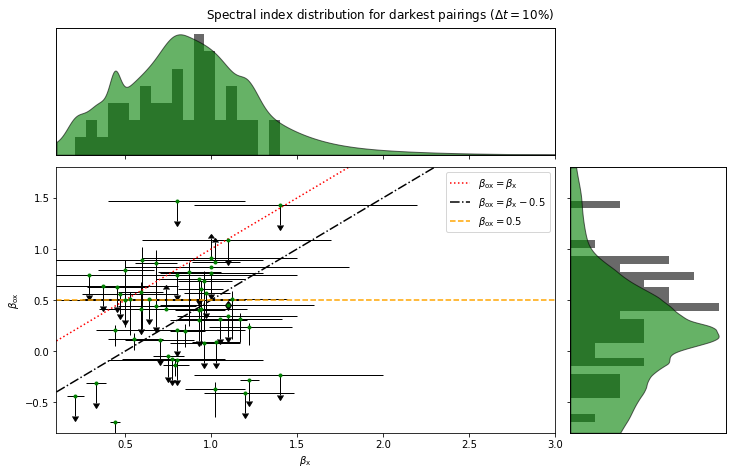

In [27]:
fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

ax_main = fig.add_subplot(grid[1:-1, 0:-1])
ax_right = fig.add_subplot(grid[1:-1, -1], xticklabels=[], yticklabels=[])
ax_top = fig.add_subplot(grid[0, 0:-1], xticklabels=[], yticklabels=[])

x = np.linspace(0.1,3,500)
y = np.linspace(-.8,1.8,500)

ax_main.errorbar(b_x,b_ox,xerr=[xminus,xplus],yerr=[oxminus,oxplus],
                 uplims=oxuplims,lolims=oxlolims,
                 linestyle="",marker=".",mfc="g",mec="g",ecolor="k",elinewidth=1,capthick=1)
ax_main.plot(x,x,"r:",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}$")
ax_main.plot(x,x-.5,"k-.",label=r"$\beta_\mathrm{ox}=\beta_\mathrm{x}-0.5$")
ax_main.plot(x,[.5]*len(x),linestyle="--",color="orange",label=r"$\beta_\mathrm{ox}=0.5$")
ax_main.set(xlim=(x.min(),x.max()),ylim=(y.min(),y.max()),
            xlabel=r"$\beta_\mathrm{x}$",ylabel=r"$\beta_\mathrm{ox}$")
ax_main.legend()

# kde = stats.gaussian_kde(pd.Series(b_x)[pd.notna(b_x)])
# density = kde.evaluate(x)
ax_kde_x = ax_top.twinx()
valid_bx = darkest_times["B_x"]
ax_kde_x.fill_between(x,np.sum([bx.pdf(x) for bx in valid_bx],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_x.set_ylim(0)
ax_kde_x.set_yticks([])
ax_top.hist(b_x,19,orientation='vertical', color="dimgrey")
ax_top.set_yticks([])
ax_top.set_xlim(ax_main.get_xlim())

# kde = stats.gaussian_kde(pd.Series(b_ox)[pd.notna(b_x)])
# density = kde.evaluate(y)
ax_kde_y = ax_right.twiny()
valid_box = []
for i,row in darkest_times.iterrows():
    if np.isfinite(row["B_ox"].minus):
        neg = row["B_ox"].minus
    else:
        neg = 1
    if np.isfinite(row["B_ox"].plus):
        pos = row["B_ox"].plus
    else:
        pos = 1
    if np.isfinite(row["B_ox"].value):
        valid_box.append(AsymmetricUncertainty(row["B_ox"].value,pos,neg))
ax_kde_y.fill_betweenx(y,np.sum([box.pdf(y) for box in valid_box],axis=0),facecolor="green",edgecolor="k",alpha=.6)
ax_kde_y.set_xlim(0)
ax_kde_y.set_xticks([])
ax_right.hist(b_ox, 28, orientation='horizontal', color="dimgrey")
ax_right.set_xticks([])
ax_right.set_ylim(ax_main.get_ylim())


fig.suptitle(r"Spectral index distribution for darkest pairings ($\Delta t={}$%)".format(int(max_dt*100)), y=0.91)

plt.show()

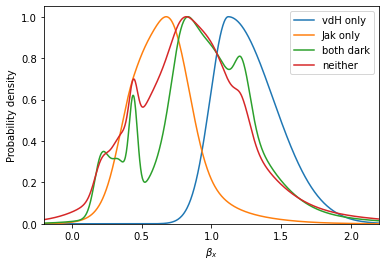

In [28]:
bspace = np.linspace(-0.2,2.2,750)
only_vdH = darkest_times.loc[darkest_times["vdH_dark"] & ~darkest_times["Jak_dark"]]
only_Jak = darkest_times.loc[darkest_times["Jak_dark"] & ~darkest_times["vdH_dark"]]
bothdark = darkest_times.loc[darkest_times["vdH_dark"] & darkest_times["Jak_dark"]]
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in only_vdH["B_x"]],axis=0)/1.773,label="vdH only")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in only_Jak["B_x"]],axis=0)/9.013,label="Jak only")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in bothdark["B_x"]],axis=0)/29.372,label="both dark")
plt.plot(bspace, np.sum([bx.pdf(bspace) for bx in darkest_times.loc[~darkest_times["Jak_dark"] & ~darkest_times["vdH_dark"],"B_x"]],axis=0)/58.807,label="neither")
plt.legend()
plt.xlim(-0.2,2.2)
plt.ylim(0)
plt.xlabel(r"$\beta_x$")
plt.ylabel("Probability density")
plt.show()

In [31]:
from code.xrt import grb_list
sGRBs["N_H (intrinsic)"] = [AsymmetricUncertainty(nh) if pd.notna(nh) else np.nan for nh in sGRBs["N_H (intrinsic)"]]
for i in sGRBs.index:
    grb = sGRBs.loc[i,"GRB"]
    print(grb,end=": ")
    if pd.notna(sGRBs.loc[i,"N_H (intrinsic)"]):
        print("already present")
        continue
    try:
        sGRBs.loc[i,"N_H (intrinsic)"],mode = get_columnDensity(grb,sGRBs)
        print("retrieved using",mode)
    except AssertionError:
        print("info doesn't exist")
    except ValueError:
        print("couldn't be parsed")
    except TypeError:
        print("trigger not found")

210413B: info doesn't exist
210410A: already present
210323A: already present
210119A: info doesn't exist
201221D: retrieved using PC
201214B: info doesn't exist
201006A: already present
200907B: already present
200826A: already present
200716C: retrieved using PC
200623A: info doesn't exist
200522A: already present
200411A: already present
200405B: info doesn't exist
200325A: trigger not found
200219A: already present
191031D: already present
190719C: already present
190627A: already present
190610A: info doesn't exist
190427A: info doesn't exist
190326A: info doesn't exist
181126A: already present
181123B: already present
180805B: already present
180805A: retrieved using PC
180727A: already present
180718A: info doesn't exist
180715A: info doesn't exist
180618A: already present
180418A: already present
180402A: already present
180204A: already present
171103A: info doesn't exist
170827A: already present
170822A: already present
170728B: already present
170728A: already present
170524

Text(0.5, 1.0, 'Hydrogen column densities by category')

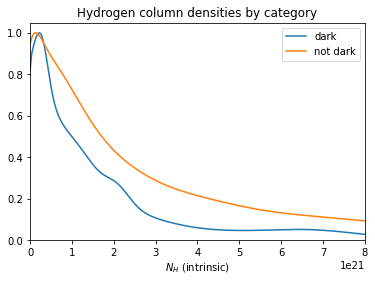

In [63]:
dark_nh = sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# dark_nh = [v for v in dark_nh if v.value>0]
notdark_nh = sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"]
# notdark_nh = [v for v in notdark_nh if v.value>0]
max_x = 8e21
x = np.linspace(0,max_x,10000)
p_NH_dark = np.sum([nh.pdf(x) for nh in dark_nh],axis=0)
plt.plot(x,p_NH_dark/max(p_NH_dark),label="dark")
p_NH_notdark = np.sum([nh.pdf(x) for nh in notdark_nh],axis=0)
plt.plot(x,p_NH_notdark/max(p_NH_notdark),label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Hydrogen column densities by category")
# plt.savefig("./products/NH_dists.png",dpi=300,bbox_inches="tight",facecolor="white",transparent=False)

Text(0.5, 1.0, 'Cumulative distributions of Hydrogen column density')

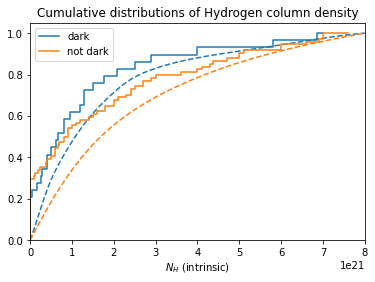

In [66]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark),color="tab:blue",linestyle="--")
plt.plot(x,np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark),color="tab:orange",linestyle="--")
x1 = np.sort([v.value for v  in dark_nh if v.value<max_x])
plt.step(x1, np.linspace(0, 1, len(x1)), where="pre", label="dark")
x2 = np.sort([v.value for v  in notdark_nh if v.value<max_x])
plt.step(x2, np.linspace(0, 1, len(x2)), where="pre", label="not dark")
plt.xlabel("$N_H$ (intrinsic)")
plt.xlim(0,max_x)
plt.ylim(0)
plt.legend()
plt.title("Cumulative distributions of Hydrogen column density")

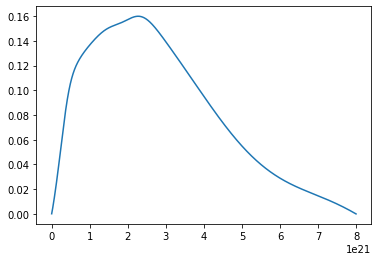

In [67]:
plt.plot(x,np.cumsum(p_NH_dark)/np.sum(p_NH_dark)-np.cumsum(p_NH_notdark)/np.sum(p_NH_notdark))

In [68]:
stats.ks_2samp(sGRBs.loc[~sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"],
               sGRBs.loc[sGRBs["GRB"].isin(dark["GRB"]) & sGRBs["N_H (intrinsic)"].notna(), "N_H (intrinsic)"])

KstestResult(statistic=0.2611721611721612, pvalue=0.0722566338498557)

### Observation depth over time

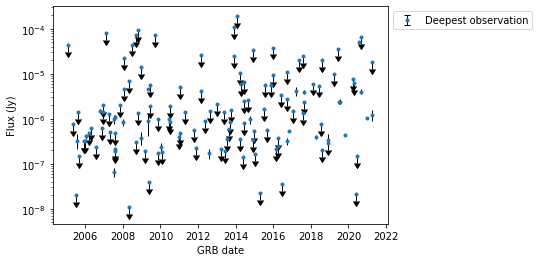

In [69]:
fig = plt.figure()
datestamps = []
deepests = []
for grb,opt in all_optical.dropna(subset=["Flux (Jy)"]).groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    deepest_obs = min(opt["Flux (Jy)"])
    if pd.notna(deepest_obs):
        datestamps.append(mm+"/"+dd+"/20"+yy)
        deepests.append(deepest_obs)
datestamps = pd.to_datetime(datestamps)
vals = [v.value for v in deepests]
pos = [0.3*v.value if np.isinf(v.plus) else v.plus for v in deepests]
neg = [0.3*v.value if np.isinf(v.minus) else v.minus for v in deepests]
plt.errorbar(datestamps,[d.value for d in deepests],yerr=(neg,pos),linestyle="",marker=".",
             ecolor="k",elinewidth=1,label="Deepest observation",
             uplims=[np.isinf(point.minus) for point in deepests],
                lolims=[np.isinf(point.plus) for point in deepests],capsize=0)
#plt.plot(df.Date,df.Value,":",label=r"Log regression (R$^2=%.2f$)"%(r*r))
plt.yscale("log")
plt.ylabel("Flux (Jy)")
plt.xlabel("GRB date")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()
fig.savefig("./products/deepest_over_time.png",bbox_inches="tight",dpi=300)

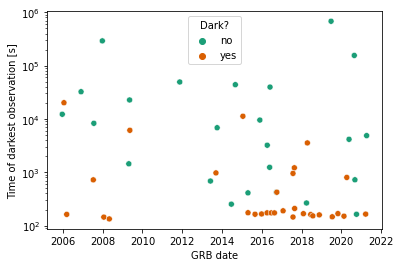

In [70]:
fig,ax = plt.subplots()
datestamps = []
darkest_t = []
cs = []
for grb,data in results.groupby("GRB"):
    yy = grb[:2]
    mm = grb[2:4]
    dd = grb[4:6]
    datestamps.append(mm+"/"+dd+"/20"+yy)
    point = data.loc[data["B_ox"]==data["B_ox"].min(),:]
    darkest_t.append(float(point["t_o"]))
    if all(point["Jak_dark"]) or all(point["vdH_dark"]):
        cs.append("yes")
    else:
        cs.append("no")
    
datestamps = pd.to_datetime(datestamps)
sns.scatterplot(x="Date",y="Time",hue="Dark?",palette="Dark2",
                data=pd.DataFrame(zip(datestamps,darkest_t,cs),
                                  columns=["Date","Time","Dark?"]))
plt.xlabel("GRB date")
plt.ylabel("Time of darkest observation [s]")
plt.yscale("log")
plt.show()

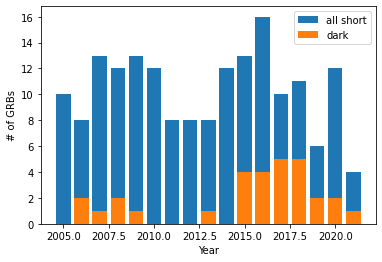

10.352941176470589 ± 0.7323470351758077 short bursts per year
1.875 ± 0.4366062299143245 dark short bursts per year


In [71]:
addYear(sGRBs)
addYear(all_optical)
addYear(results)
addYear(dark)
    
dark_year_counts = {}
all_year_counts = {}
for year,sample in dark.groupby("Year"):
    dark_year_counts[year] = len(sample["GRB"].unique())
for year in range(2006,2022):
    if year not in dark_year_counts.keys():
        dark_year_counts[year] = 0
        
for year,sample in sGRBs.groupby("Year"):
    all_year_counts[year] = len(sample["GRB"].unique())
for year in range(2005,2022):
    if year not in all_year_counts.keys():
        all_year_counts[year] = 0
plt.bar(all_year_counts.keys(),all_year_counts.values(),label="all short")
plt.bar(dark_year_counts.keys(),dark_year_counts.values(),label="dark")
plt.xlabel("Year")
plt.ylabel("# of GRBs")
plt.legend()
plt.show()
print(np.mean(list(all_year_counts.values())),"±",stats.sem(list(all_year_counts.values())),"short bursts per year")
print(np.mean(list(dark_year_counts.values())),"±",stats.sem(list(dark_year_counts.values())),"dark short bursts per year")

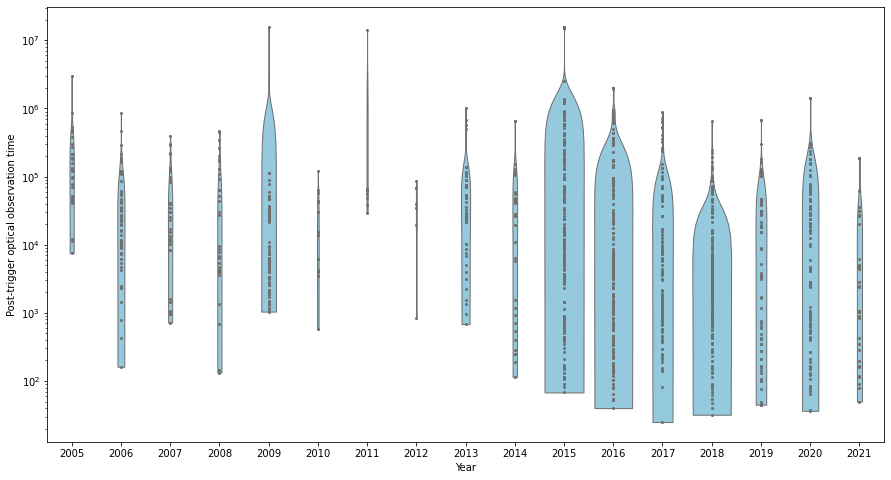

In [72]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="Time (s)",data=all_optical,color="skyblue",linewidth=1,
               scale="count",cut=0,bw=0.5,inner="point",ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
# plt.ylim(10,1e6)

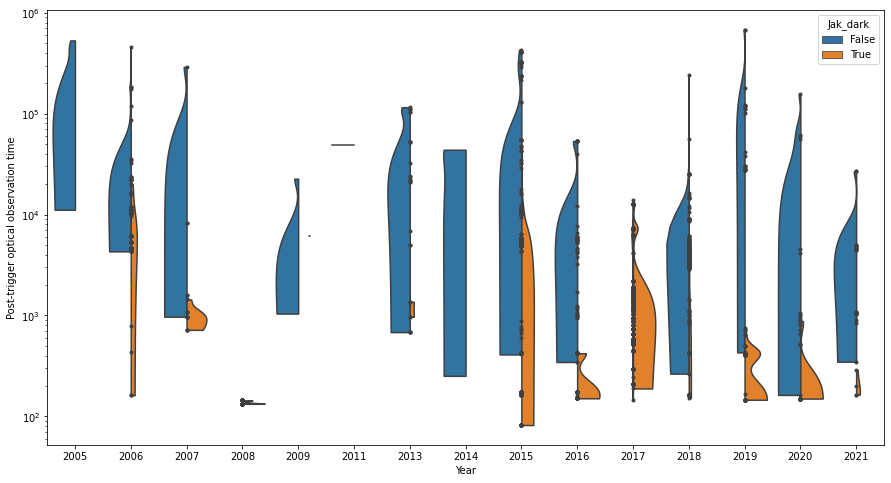

In [73]:
fig,ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="Year",y="t_o",data=results[(results["t_o"]<1e6) & (results["Year"]>2004)],
               scale="count",inner="point",cut=0,hue="Jak_dark",split=True,ax=ax)
plt.ylabel("Post-trigger optical observation time")
plt.yscale("log")
#plt.ylim(1,1e5)

## Illustrative example plot

GRB                                                    060121
t_o                                                   20160.0
dt%                                                  0.075713
nu_o                                        428274940000000.0
F_o                                         1.1e-06 ± 2.2e-07
nu_x        4.1880632448032506e+17 (+1.9991731172900093e+1...
F_x             1.291982740240172e-07 ± 3.234643131721272e-08
B_ox        0.3110520372331474 (+0.059581187249701996, -0....
B_x                                       1.17 (+0.24, -0.23)
Jak_dark                                                 True
vdH_dark                                                 True
Year                                                     2006
Name: 1315, dtype: object

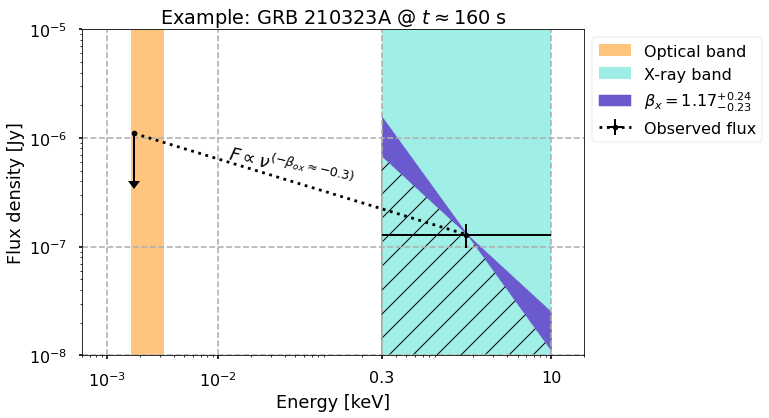

In [74]:
display(results.loc[1315,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)
beta = results.loc[1315,"B_x"]
E_o = results.loc[1315,"nu_o"]*6.62607015e-34/1.6021773e-16
E_x = results.loc[1315,"nu_x"]*6.62607015e-34/1.6021773e-16
F_o = results.loc[1315,"F_o"]
F_x = results.loc[1315,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x.value],[F_o.value,F_x.value],xerr=[(0,E_x.minus),(0,E_x.plus)],
             yerr=[(7e-7,F_x.minus),(0,F_x.plus)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label="$\\beta_x=%.2f_{-%.2f}^{+%.2f}$" %(beta.value,beta.minus,beta.plus))
plt.text(1.2e-2,3.5e-7,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.3})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(6e-4,20)
plt.ylim(1e-8,1e-5)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 210323A @ $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./products/160624A.png",bbox_inches="tight",dpi=300)

## To-do

- compare $\beta_x$ distributions between vdH/Jakobsson dark bursts
    - dark between each method
    - dark vs non-dark for each method
- for dark but have optical detections, estimate extinctions ($A_v$)
    - if $\beta_x = \beta_{ox}$ (straight spectrum)
    - if it is -0.5 (assumed dark)
- $N_H$ vs. $\beta_{ox}$ plot and vs. $A_v$
- distribution of $N_H$: are dark mostly at the high end?
- deepest observation of each GRB over time -- have we gotten better at chasing them?
    - some indicator of how early we catch them?
    - at what time are GRBs dark?
- where are my early-time observations from? 
    - check David's tables
    - check Rastinejad, Fong sources
- interpolate XRT light curve to make data matches: does that get us more dark bursts?